In [1]:
# System imports
import os
import sys

# Import packages
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import seaborn as sns

from scipy.stats import levene
import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import statsmodels.api as sm

from pyhrv import frequency_domain
from pyhrv import nonlinear
from pyhrv import hrv
from pyhrv import tools



In [2]:
# Load data
patient_info = pd.read_csv("hyperaktiv/patient_info.csv", sep=";")

patient_info.head()


,ID,SEX,AGE,ACC,ACC_TIME,ACC_DAYS,HRV,HRV_TIME,HRV_HOURS,CPT_II,...,HADS_D,MED,MED_Antidepr,MED_Moodstab,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$
0,1,0,3,1,16:00:00,6.0,1,11:00:00,21.0,0,...,2.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,0,4,1,10:54:00,6.8,0,NaN,NaN,1,...,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,1,2,1,15:28:00,7.2,1,15:25:00,21.0,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,1,3,0,NaN,NaN,1,16:55:00,22.0,1,...,6.0,1,1.0,NaN,NaN,1.0,NaN,1.0,NaN,0
4,5,1,1,1,14:24:00,5.9,1,16:00:00,12.0,1,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
HRV_DF = patient_info[patient_info['HRV']==1]
HRV_DF = HRV_DF[["ID", "SEX", "AGE", "ADHD", "HRV", "HRV_TIME", "HRV_HOURS"]]
HRV_DF["HRV_TIME_delta"] = pd.to_timedelta(HRV_DF.HRV_TIME)
HRV_DF["HRV_TIME_float"] = HRV_DF["HRV_TIME_delta"] / pd.offsets.Hour(1)

print(HRV_DF)

      ID  SEX  AGE  ADHD  HRV  HRV_TIME  HRV_HOURS  HRV_TIME_delta  \
0      1    0    3     1    1  11:00:00       21.0 0 days 11:00:00   
2      3    1    2     1    1  15:25:00       21.0 0 days 15:25:00   
3      4    1    3     1    1  16:55:00       22.0 0 days 16:55:00   
4      5    1    1     1    1  16:00:00       12.0 0 days 16:00:00   
5      7    0    3     0    1  10:20:00       21.0 0 days 10:20:00   
..   ...  ...  ...   ...  ...       ...        ...             ...   
94    98    0    3     1    1  15:00:00       17.0 0 days 15:00:00   
97   101    1    1     0    1  14:30:00       21.0 0 days 14:30:00   
98   103    1    4     0    1  09:26:00       22.0 0 days 09:26:00   
99   104    0    2     0    1  12:00:00       22.0 0 days 12:00:00   
100  105    1    4     0    1  13:25:00       13.0 0 days 13:25:00   

     HRV_TIME_float  
0         11.000000  
2         15.416667  
3         16.916667  
4         16.000000  
5         10.333333  
..              ...  
94   

Plots 

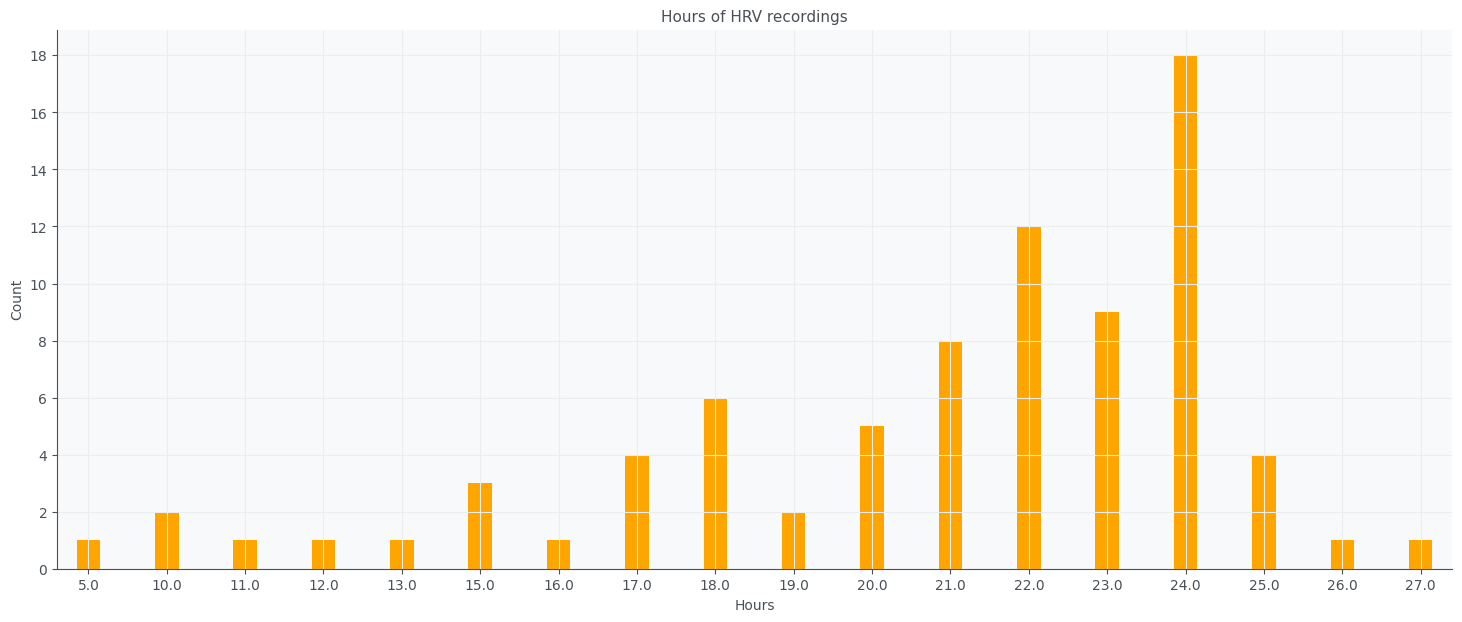

In [4]:
%matplotlib inline 
# Plot number of hours of HRV recordings

plt.figure(figsize=(18,7))
plt.title("Hours of HRV recordings")
plt.xlabel("Hours")
plt.ylabel("Count")
#plt.axis([5, 28, 0, 20])
plt.locator_params(axis="both", integer=True, nbins= 10)
HRV_DF.HRV_HOURS.value_counts().sort_index().plot(kind="bar", rot=0, width=0.3, color="orange")

plt.show()

Plotting HRV recording hours 

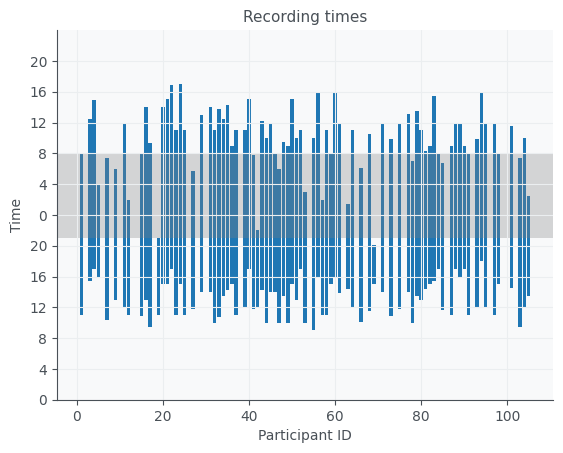

In [5]:
# Plotting HRV recording hours

ax = plt.bar(HRV_DF.ID, HRV_DF.HRV_HOURS, bottom=HRV_DF.HRV_TIME_float, label= "HRV recording hours")
plt.ylim(bottom=0, top=48)
plt.yticks(range(0, 48, 4), labels=list(range(0,24,4)) + list(range(0,24,4)))

plt.axhspan(21, 21+3+8, facecolor='grey', alpha=0.3)
plt.xlabel("Participant ID")
plt.ylabel("Time")
plt.title("Recording times")
plt.savefig('Recording_times.png')

plt.show()


Time domain analysis of HRV data

In [6]:
# Setting Timestamp column as index
HRV_1 = pd.read_csv("hyperaktiv/hrv_data/patient_hr_1.csv", sep=";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])

HRV_1.head()

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:02.295,631.84
2009-03-04 11:00:02.927,624.02
2009-03-04 11:00:03.551,636.72
2009-03-04 11:00:04.188,625.98


In [7]:
HRV_1.index

DatetimeIndex([       '2009-03-04 11:00:00', '2009-03-04 11:00:02.295000',
               '2009-03-04 11:00:02.927000', '2009-03-04 11:00:03.551000',
               '2009-03-04 11:00:04.188000', '2009-03-04 11:00:04.813000',
               '2009-03-04 11:00:05.446000', '2009-03-04 11:00:06.097000',
               '2009-03-04 11:00:06.753000', '2009-03-04 11:00:07.409000',
               ...
               '2009-03-05 08:07:27.530000', '2009-03-05 08:07:28.193000',
               '2009-03-05 08:07:28.864000', '2009-03-05 08:07:29.540000',
               '2009-03-05 08:07:30.230000', '2009-03-05 08:07:30.918000',
               '2009-03-05 08:07:31.590000', '2009-03-05 08:07:32.260000',
               '2009-03-05 08:07:32.931000', '2009-03-05 08:07:33.593000'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=107474, freq=None)

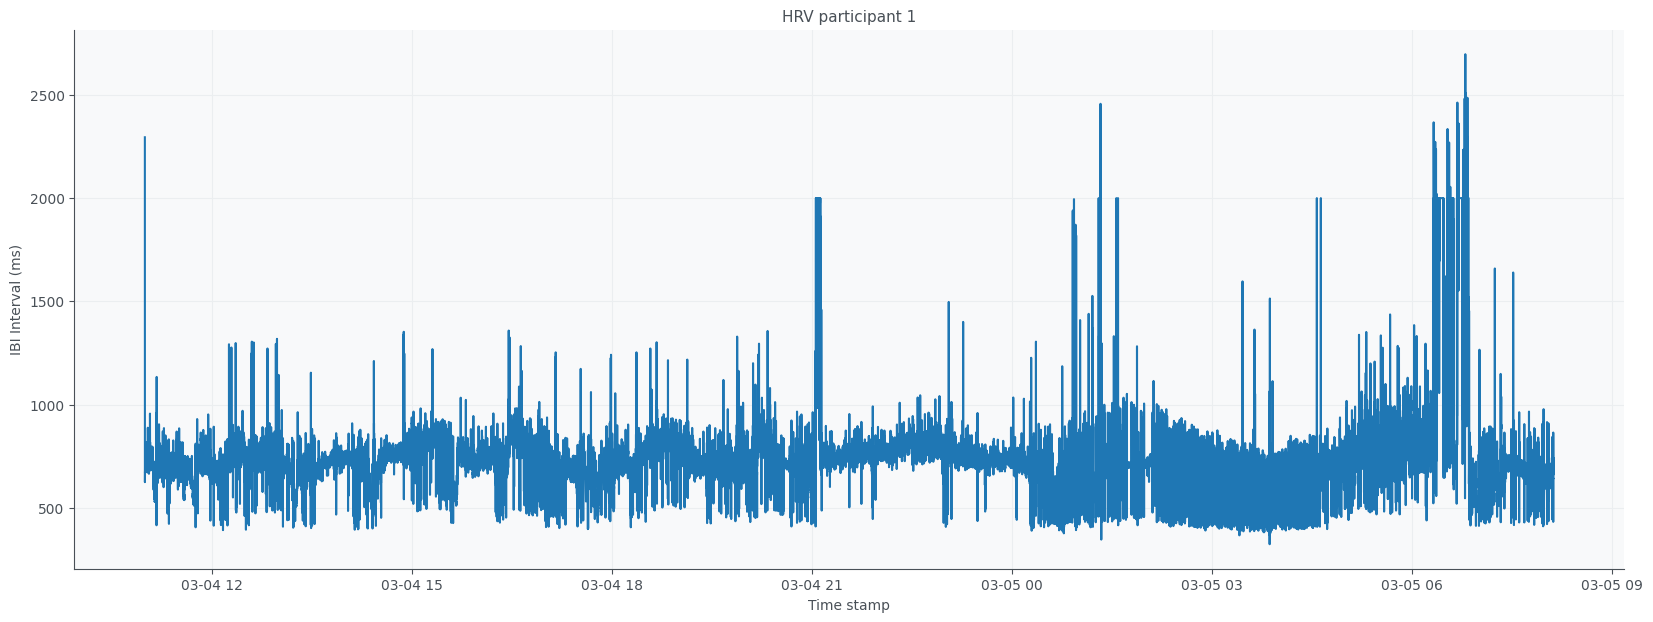

In [8]:
# Plot the HRV values and the timestamps.

plt.figure(figsize=(20, 7))
plt.title("HRV participant 1")
plt.xlabel("Time stamp")
plt.ylabel("IBI Interval (ms)")

plt.plot(HRV_1.HRV)
plt.show()

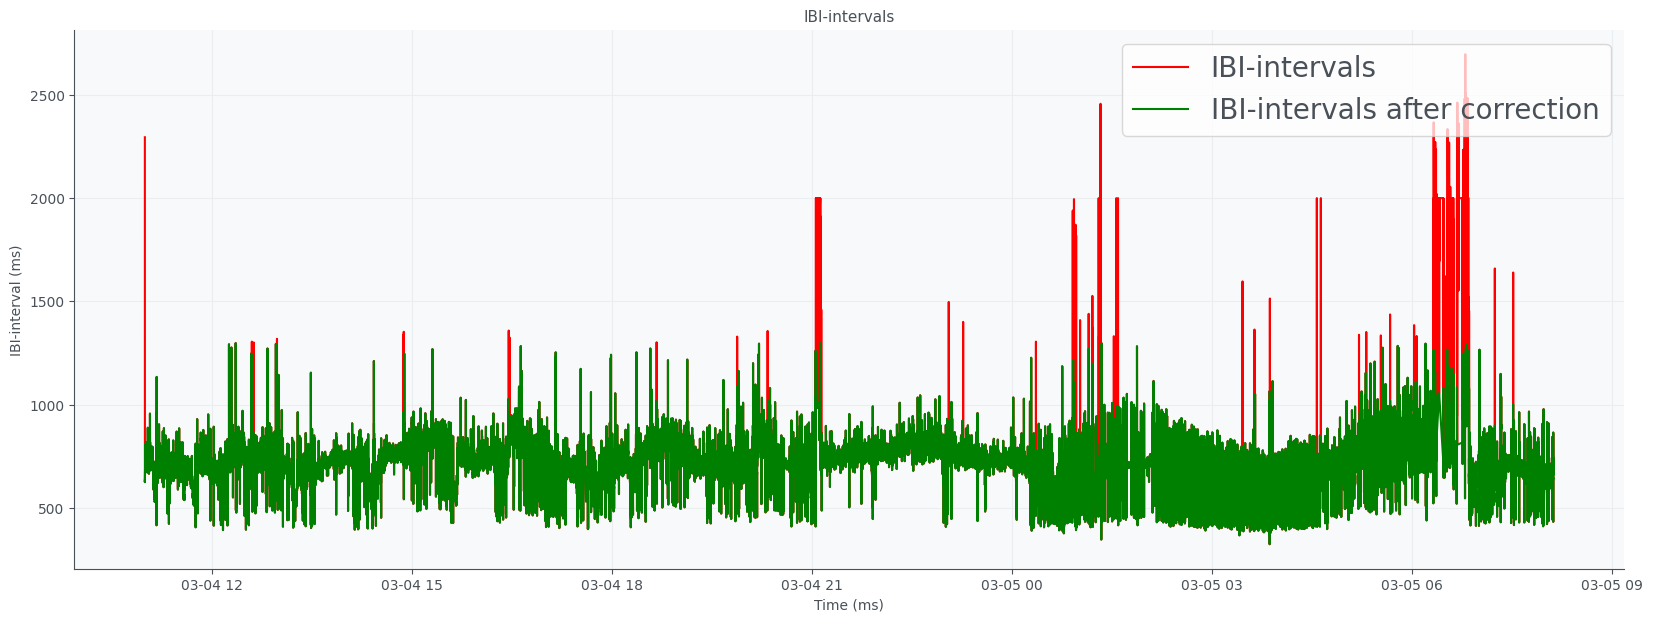

In [9]:
# For plotting, create a copy of the original HRV column and call it raw - it gets to keep the outliers
HRV_1_raw = HRV_1.HRV

# Turn every value below 300ms and above 1300ms to NaN
HRV_1['HRV'] = np.where((300 <= HRV_1['HRV']) & (HRV_1['HRV'] <= 1300), HRV_1['HRV'], np.nan)

# Fill NaN with interpolated value
HRV_1_cor = HRV_1['HRV'].interpolate(method='linear', axis=0).ffill().bfill()

plt.figure(figsize=(20, 7))

plt.title("IBI-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("IBI-interval (ms)")

plt.plot(HRV_1_raw, color="red", label="IBI-intervals")
plt.plot(HRV_1_cor, color="green",  label="IBI-intervals after correction")
plt.legend(fontsize = "20")
plt.show()

Dropping all data between 21:00 - 08:00


In [10]:
# Dropping all data between 21:00 - 08:00 for participant 1

HRV_1 = HRV_1[(HRV_1.index.hour >= 8) & (HRV_1.index.hour <= 20)]

print(HRV_1)

                            HRV
TIMESTAMP                      
2009-03-04 11:00:00.000     NaN
2009-03-04 11:00:02.295  631.84
2009-03-04 11:00:02.927  624.02
2009-03-04 11:00:03.551  636.72
2009-03-04 11:00:04.188  625.98
...                         ...
2009-03-05 08:07:30.918  671.88
2009-03-05 08:07:31.590  669.92
2009-03-05 08:07:32.260  670.90
2009-03-05 08:07:32.931  662.11
2009-03-05 08:07:33.593  672.85

[51261 rows x 1 columns]


Replace outliers using interpolation - everything below 300ms and above 1300 ms

Trying for one participant first and plotting to see how well it worked.

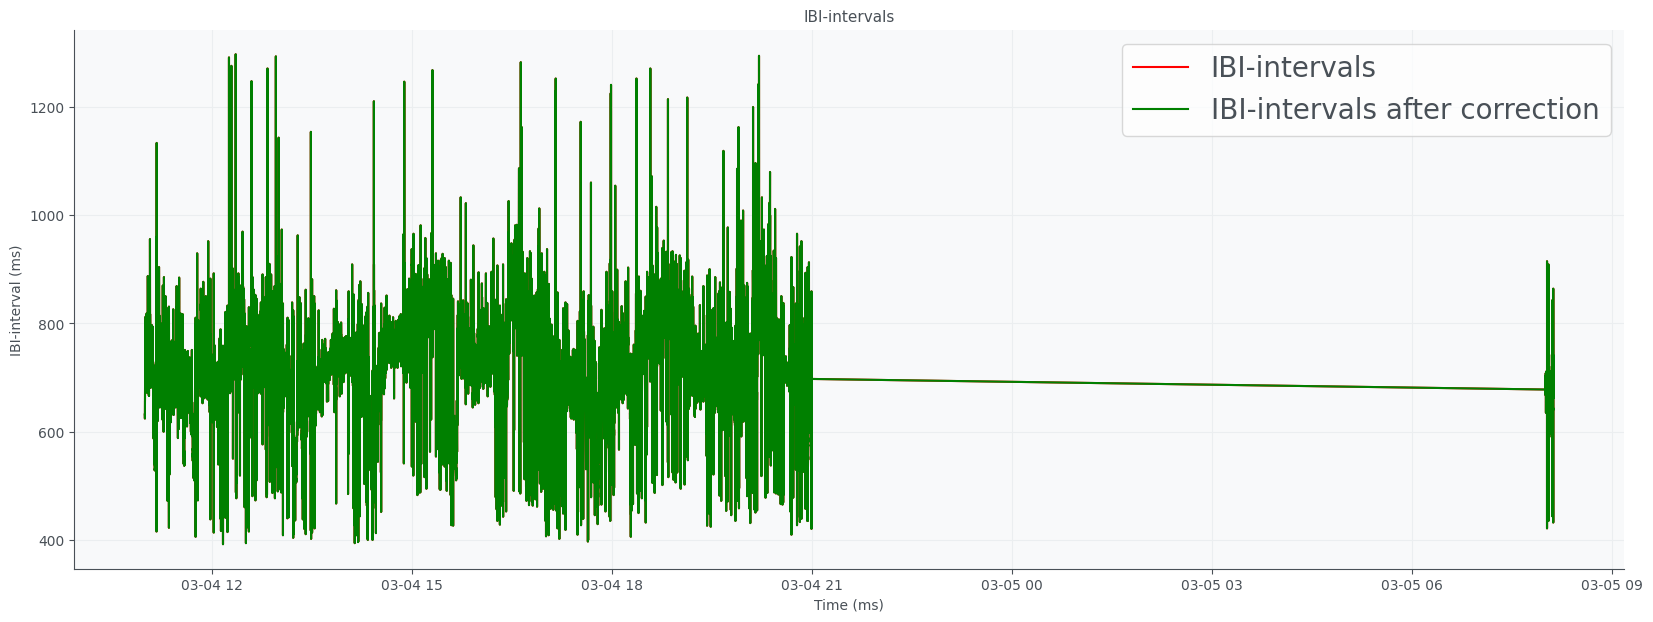

In [11]:
# For plotting, create a copy of the original HRV column and call it raw - it gets to keep the outliers
HRV_1_raw = HRV_1.HRV

# Turn every value below 300ms and above 1300ms to NaN
HRV_1['HRV'] = np.where((300 <= HRV_1['HRV']) & (HRV_1['HRV'] <= 1300), HRV_1['HRV'], np.nan)

# Fill NaN with interpolated value
HRV_1_cor = HRV_1['HRV'].interpolate(method='linear', axis=0).ffill().bfill()

plt.figure(figsize=(20, 7))

plt.title("IBI-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("IBI-interval (ms)")

plt.plot(HRV_1_raw, color="red", label="IBI-intervals")
plt.plot(HRV_1_cor, color="green",  label="IBI-intervals after correction")
plt.legend(fontsize = "20")
plt.show()

In [12]:
# Time domain analysis of Participant 1

def timedomain(HRV_1_cor):
    results = {}

    hr = 60000/HRV_1_cor #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI (ms)'] = np.mean(HRV_1_cor)
    results['SDNN (STD IBI) (ms)'] = np.std(HRV_1_cor)  # I want SDANN + SDNN index
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(HRV_1_cor)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(HRV_1_cor))))
    results['NN50'] = np.sum(np.abs(np.diff(HRV_1_cor)) > 50)*1  
    results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(HRV_1_cor)) > 50)*1) / len(HRV_1_cor) 
    return results


print("Time domain metrics - IBI-intervals:")
for k, v in timedomain(HRV_1_cor).items():
    print("- %s: %.2f" % (k, v))


print(" ")


Time domain metrics - IBI-intervals:
- Mean IBI (ms): 711.03
- SDNN (STD IBI) (ms): 82.16
- Mean HR (Kubios' style) (beats/min): 84.38
- Mean HR (beats/min): 85.57
- STD HR (beats/min): 10.44
- Min HR (beats/min): 46.23
- Max HR (beats/min): 153.22
- RMSSD (ms): 44.49
- NN50: 2133.00
- pNN50 (%): 4.16
 


Create a function for time domain analysis

In [13]:
def timedomain(x):
    results = {}

    hr = 60000/x.HRV #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI'] = round(np.mean(x.HRV), 3)
    results['SDNN'] = round(np.std(x.HRV), 3) 
    results['Mean HR'] = round(60000/np.mean(x.HRV), 3)
    results['STD HR'] = round(np.std(hr), 3)
    results['Min HR'] = round(np.min(hr), 3)
    results['Max HR'] = round(np.max(hr), 3)
    results['RMSSD'] = round(np.sqrt(np.mean(np.square(np.diff(x.HRV)))), 3)
    results['NN50'] = np.sum(np.abs(np.diff(x.HRV)) > 50)*1
    results['pNN50'] = round(100 * np.sum((np.abs(np.diff(x.HRV)) > 50)*1) / len(x.HRV), 3)
    return results



Create a loop that removes everything between 08:00 and 21:00, replaces outliers with interpolated values, and runs time domain analysis on every participant file

In [14]:
# Create a list object 
HRV_data = []

# Create list of datafiles

data_files = glob.glob("hyperaktiv/hrv_data/*.csv")

# For every file in the hrv_data folder:
for file in data_files:
    data = pd.read_csv(file, sep = ";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])
    data = data[(data.index.hour >= 8) & (data.index.hour <= 20)]
    data['HRV'] = np.where((300 <= data['HRV']) & (data['HRV'] <= 1300), data['HRV'], np.nan)
    data['HRV'] = data['HRV'].interpolate(method='linear', axis=0).ffill().bfill()
    results = timedomain(data)
    HRV_data.append(results)




# Convert list to dataframe
HRV_df = pd.DataFrame(HRV_data)
# Print head of the dataframe
    
HRV_df.head()


,Mean IBI,SDNN,Mean HR,STD HR,Min HR,Max HR,RMSSD,NN50,pNN50
0,711.032,82.162,84.384,10.443,46.230,153.218,44.494,2133,4.161
1,759.993,220.028,78.948,26.338,46.161,199.481,86.854,10657,21.935
2,634.521,125.293,94.560,17.988,46.195,198.834,47.913,2936,4.561
3,663.711,101.498,90.401,12.656,46.475,199.481,35.514,4202,6.917
4,596.728,95.721,100.548,15.360,46.161,199.481,45.602,1159,2.565


In [15]:
# Add ADHD, age, sex, and HRV_Hours column
extract = HRV_DF[["ADHD", "AGE", "SEX", "HRV_HOURS"]]

extract = extract.reset_index(drop=True)
print(extract)

    ADHD  AGE  SEX  HRV_HOURS
0      1    3    0       21.0
1      1    2    1       21.0
2      1    3    1       22.0
3      1    1    1       12.0
4      0    3    0       21.0
..   ...  ...  ...        ...
75     1    3    0       17.0
76     0    1    1       21.0
77     0    4    1       22.0
78     0    2    0       22.0
79     0    4    1       13.0

[80 rows x 4 columns]


In [16]:
HRV_df = extract.join(HRV_df)

print(HRV_df)

    ADHD  AGE  SEX  HRV_HOURS  Mean IBI     SDNN  Mean HR  STD HR  Min HR  \
0      1    3    0       21.0   711.032   82.162   84.384  10.443  46.230   
1      1    2    1       21.0   759.993  220.028   78.948  26.338  46.161   
2      1    3    1       22.0   634.521  125.293   94.560  17.988  46.195   
3      1    1    1       12.0   663.711  101.498   90.401  12.656  46.475   
4      0    3    0       21.0   596.728   95.721  100.548  15.360  46.161   
..   ...  ...  ...        ...       ...      ...      ...     ...     ...   
75     1    3    0       17.0   646.780  118.448   92.767  18.337  46.793   
76     0    1    1       21.0   652.370  112.581   91.972  15.126  46.161   
77     0    4    1       22.0   696.243   97.593   86.177  12.553  46.829   
78     0    2    0       22.0   865.000  130.559   69.364  12.130  46.161   
79     0    4    1       13.0   634.715  144.764   94.531  20.374  46.161   

     Max HR    RMSSD   NN50   pNN50  
0   153.218   44.494   2133   4.161  

Visualize and compare the groups

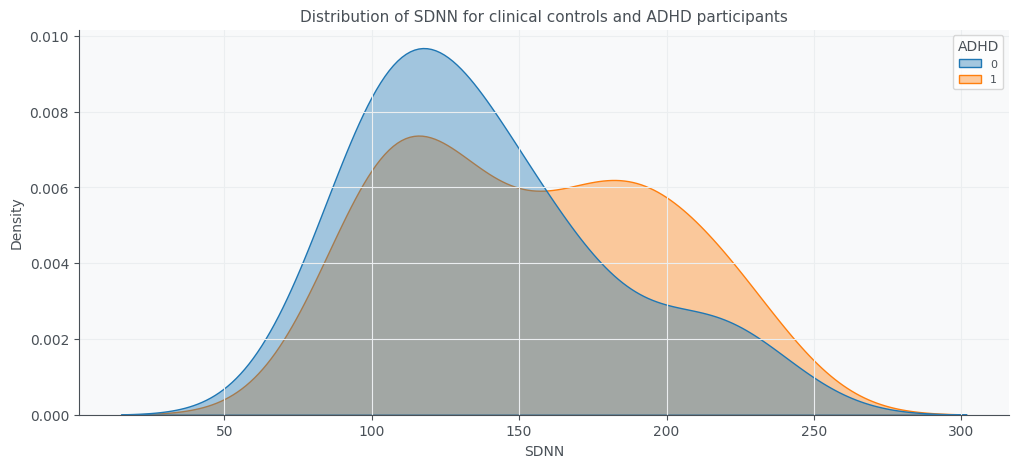

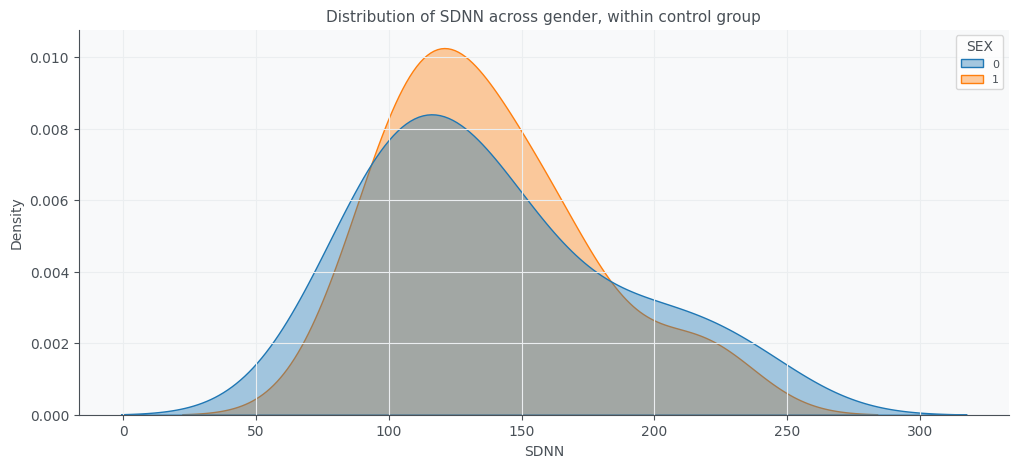

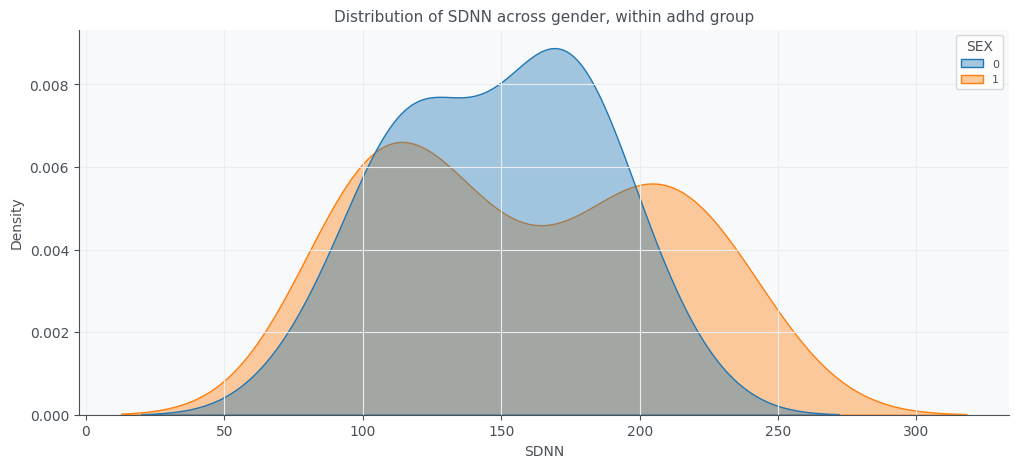

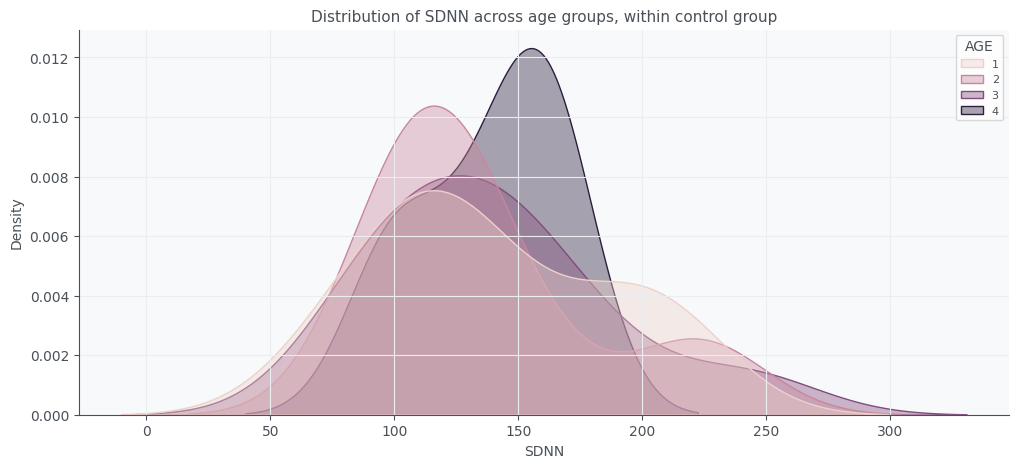

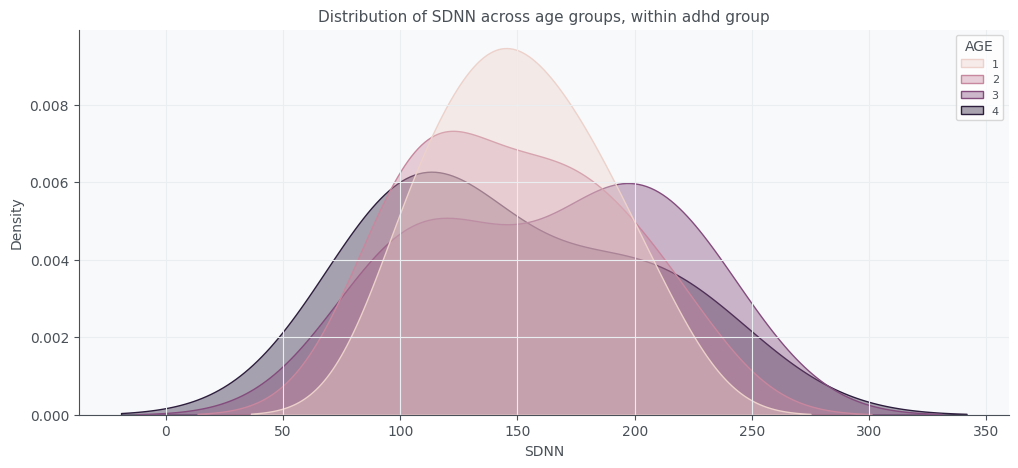

In [17]:
# Density plot 

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=HRV_df, x="SDNN", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN for clinical controls and ADHD participants')
plt.show()

# Differences in gender on only adhd participant
adhd = HRV_df.loc[(HRV_df['ADHD']== 1)]
control = HRV_df.loc[(HRV_df['ADHD']== 0)]

# Gender 
sns.kdeplot(data=control, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender, within control group')
plt.show()

# Gender 
sns.kdeplot(data=adhd, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender, within adhd group')
plt.show()



# Different age groups
sns.kdeplot(data=control, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups, within control group')
plt.show()

# Different age groups
sns.kdeplot(data=adhd, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups, within adhd group')
plt.show()



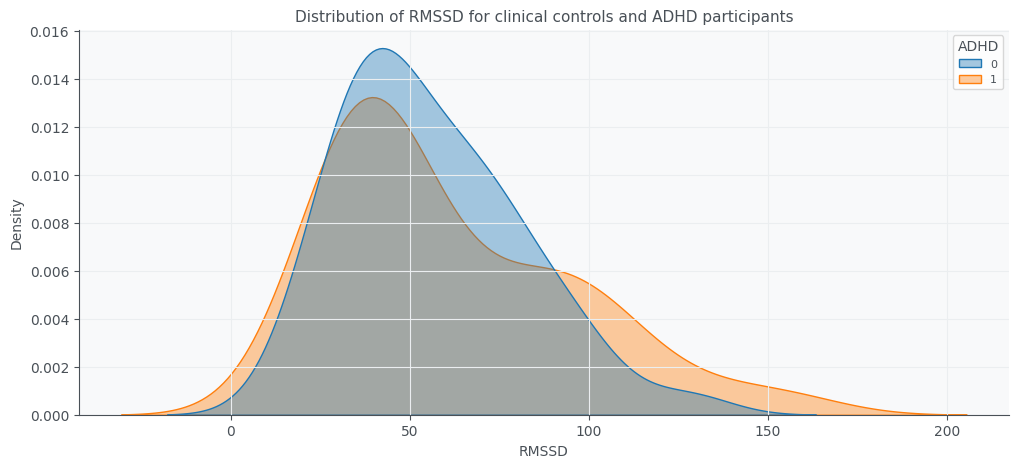

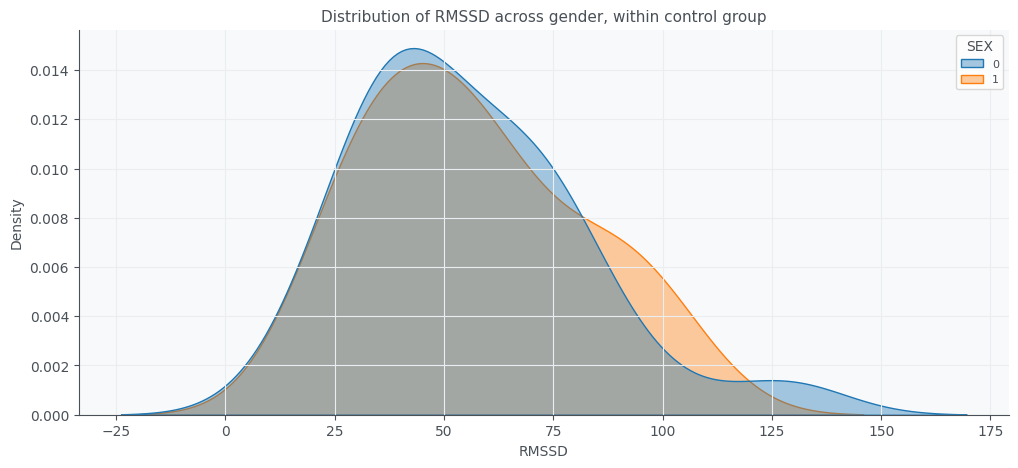

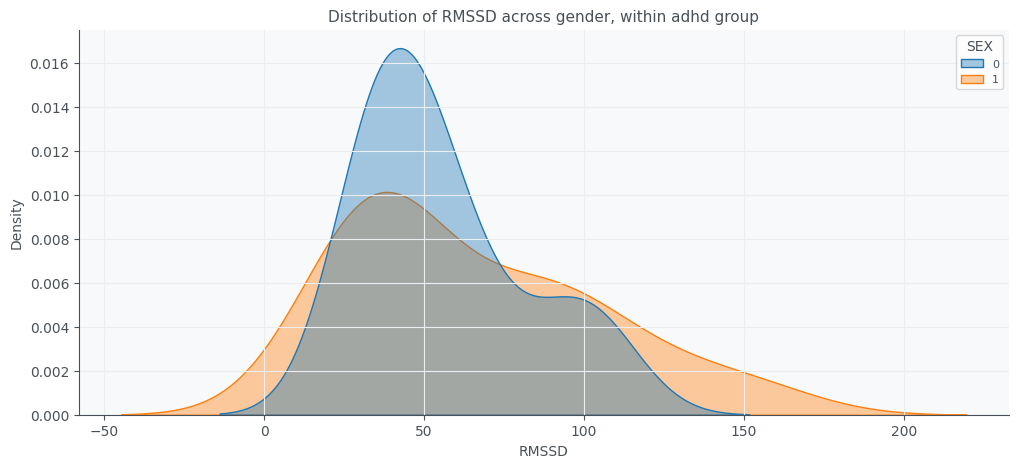

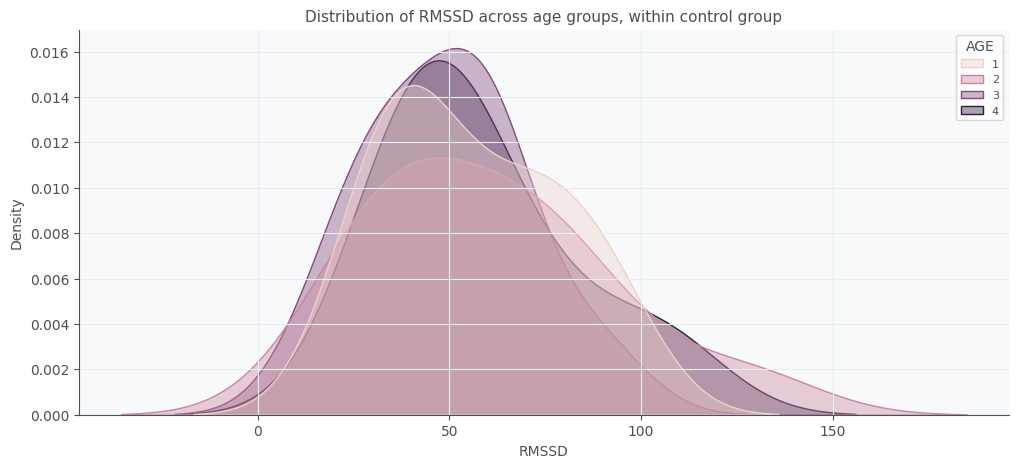

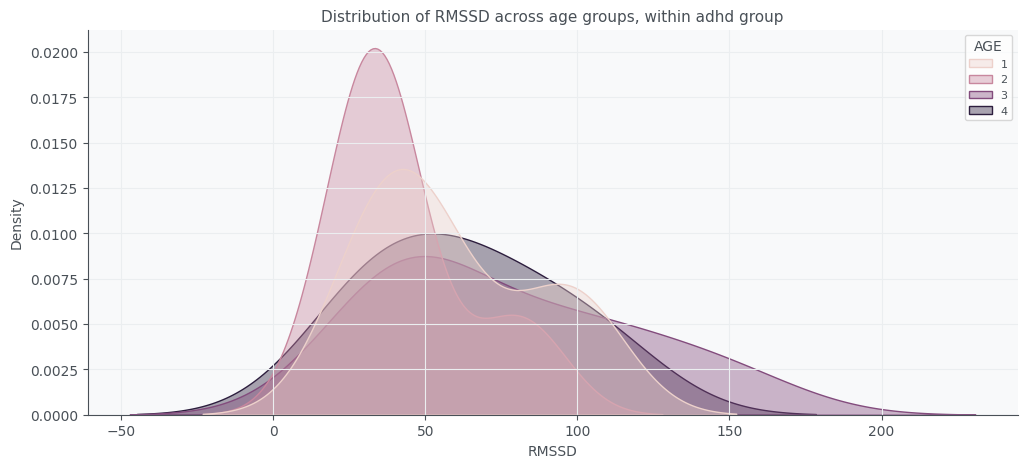

In [18]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=HRV_df, x="RMSSD", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of RMSSD for clinical controls and ADHD participants')
plt.show()


# Gender 
sns.kdeplot(data=control, x="RMSSD", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of RMSSD across gender, within control group')
plt.show()

# Gender 
sns.kdeplot(data=adhd, x="RMSSD", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of RMSSD across gender, within adhd group')
plt.show()


# Different age groups
sns.kdeplot(data=control, x="RMSSD", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of RMSSD across age groups, within control group')
plt.show()

# Different age groups
sns.kdeplot(data=adhd, x="RMSSD", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of RMSSD across age groups, within adhd group')
plt.show()


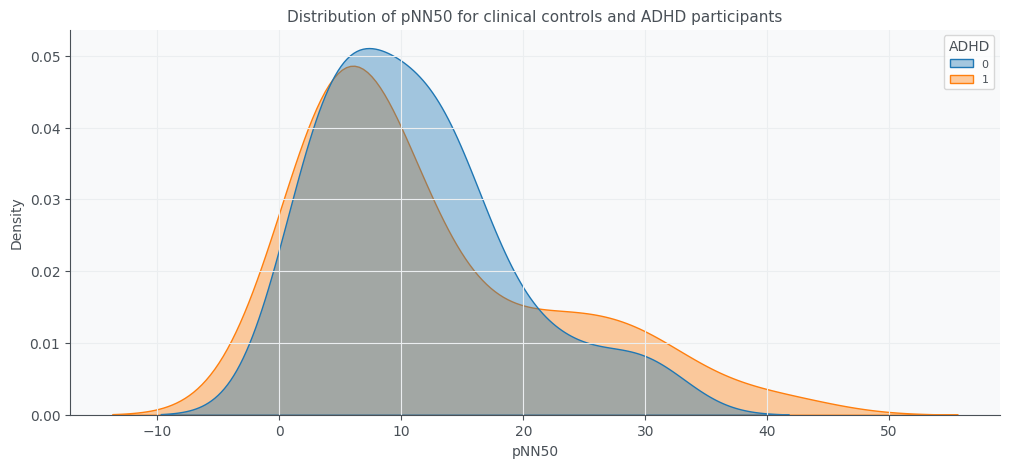

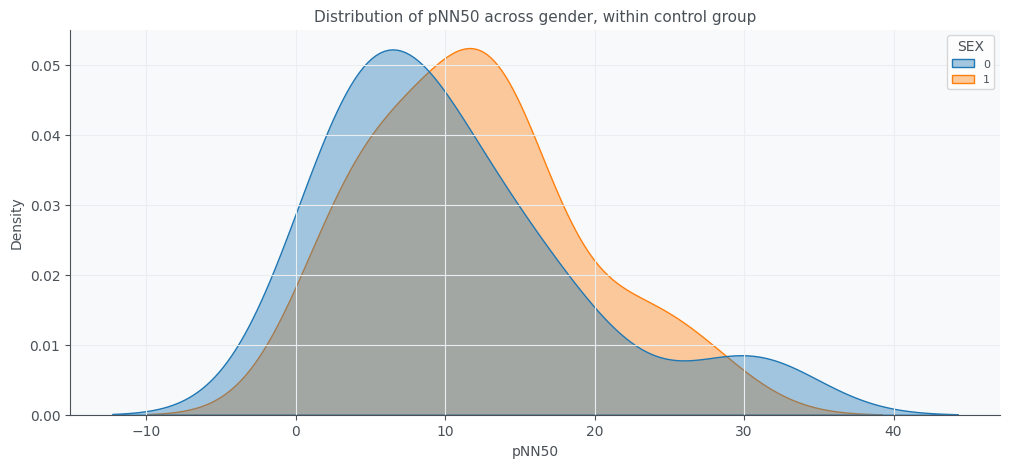

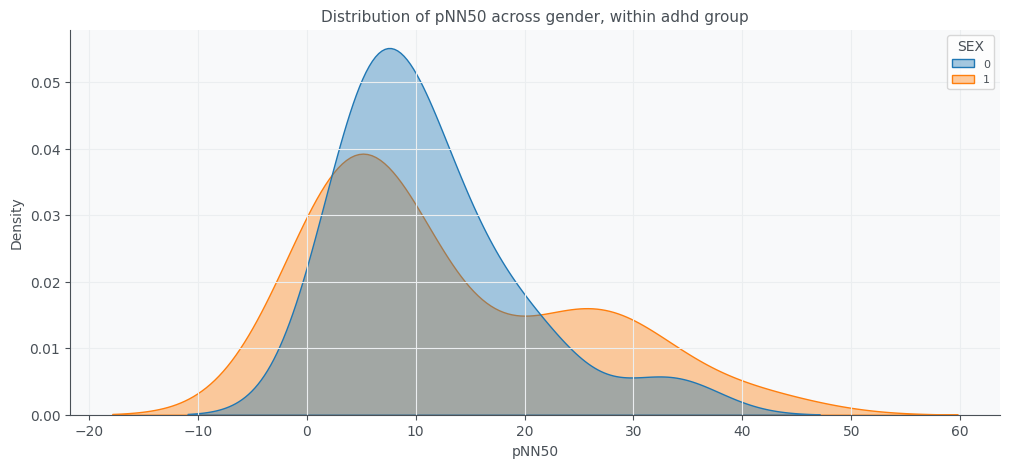

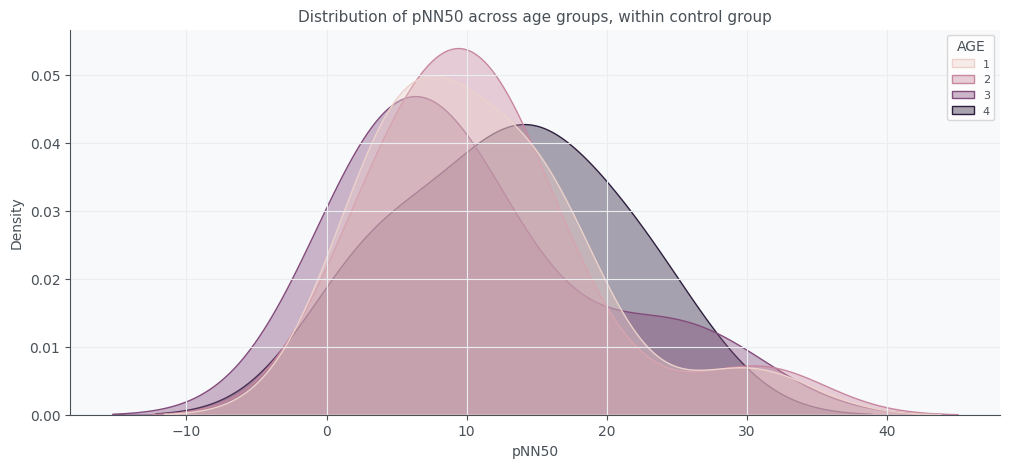

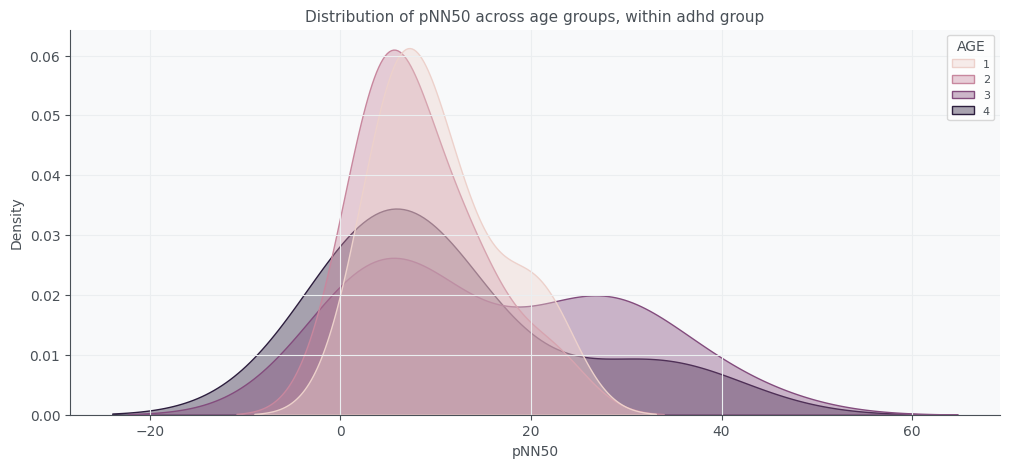

In [19]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=HRV_df, x="pNN50", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of pNN50 for clinical controls and ADHD participants')
plt.show()


# Gender 
sns.kdeplot(data=control, x="pNN50", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of pNN50 across gender, within control group')
plt.show()

# Gender 
sns.kdeplot(data=adhd, x="pNN50", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of pNN50 across gender, within adhd group')
plt.show()


# Different age groups
sns.kdeplot(data=control, x="pNN50", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of pNN50 across age groups, within control group')
plt.show()

# Different age groups
sns.kdeplot(data=adhd, x="pNN50", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of pNN50 across age groups, within adhd group')
plt.show()

Linear regression models

In [20]:
# I will be focusing on SDNN, RMSSD, and pNN50 


# See paper for model description and argumentation for choice of model structure
SDNN_model = smf.ols(formula="SDNN ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = HRV_df).fit()
print(SDNN_model.summary())

RMSSD_model = smf.ols(formula="RMSSD ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = HRV_df).fit()
print(RMSSD_model.summary())

pNN50_model = smf.ols(formula="pNN50 ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = HRV_df).fit()
print(pNN50_model.summary())




                            OLS Regression Results                            
Dep. Variable:                   SDNN   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.545
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.115
Time:                        10:53:10   Log-Likelihood:                -414.26
No. Observations:                  80   AIC:                             832.5
Df Residuals:                      78   BIC:                             837.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    138.2969      6.707     20.620      0.0

Frequency domain analysis

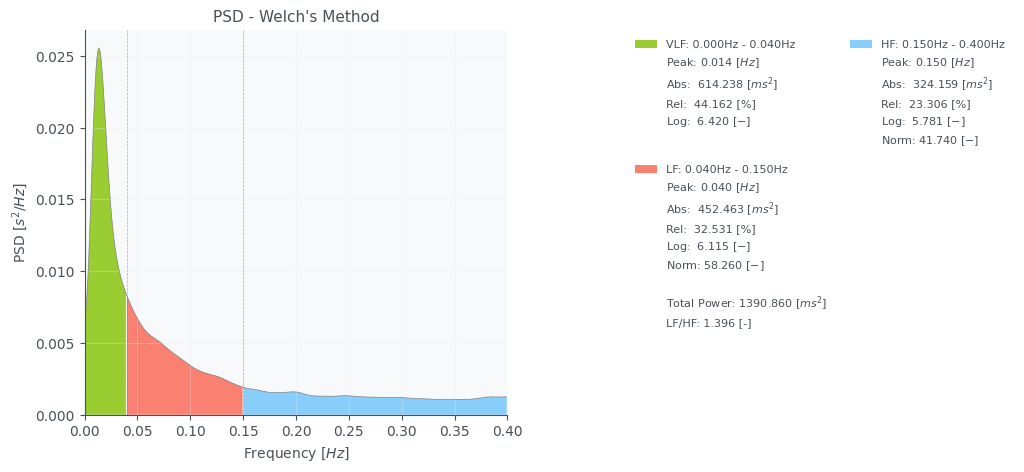

In [22]:
# Using the frequency domain function imported from the pyhrv module. Testing on Participant 1
fre = frequency_domain.welch_psd(HRV_1_cor)


Frequency domain analysis, looping through all participants

In [23]:
# Supressing output plots so I don't create 80 plots during the loop
%matplotlib agg  
%matplotlib agg


In [24]:
# Create a list object 
Fre_data = []


# Create list of datafiles

data_filesf = glob.glob("hyperaktiv/hrv_data/*.csv")

# For every file in the hrv_data folder:
for file in data_filesf:
    data = pd.read_csv(file, sep = ";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])
    data = data[(data.index.hour >= 8) & (data.index.hour <= 20)]
    data['HRV'] = np.where((300 <= data['HRV']) & (data['HRV'] <= 1300), data['HRV'], np.nan)
    data['HRV'] = data['HRV'].interpolate(method='linear', axis=0).ffill().bfill()
    results= frequency_domain.welch_psd(data["HRV"])
    Fre_data.append(results)




# Convert list to dataframe
Fre_df = pd.DataFrame(Fre_data)
# Print head of the dataframe
    
Fre_df.head()


c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotl

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.013671875, 0.0400390625, 0.150390625)","(614.2382657463203, 452.4627637354055, 324.158...","(44.162489369817095, 32.531157871488595, 23.30...","(6.420382907834723, 6.114705469666464, 5.78123...","(58.26040148341412, 41.73959851658588)",1.395806,1390.859697,Figure(1200x500),4096,hamming,4,cubic
1,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.0146484375, 0.0400390625, 0.2265625)","(2326.4810452174193, 1655.829497154426, 2195.0...","(37.66151201569002, 26.804878823840788, 35.533...","(7.752112123913203, 7.412057368988853, 7.69395...","(42.99892360332406, 57.00107639667595)",0.754353,6177.343714,Figure(1200x500),4096,hamming,4,cubic
2,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.0146484375, 0.0400390625, 0.150390625)","(983.0818941217292, 986.8053790565722, 683.006...","(37.05696230663947, 37.19731789827925, 25.7457...","(6.890692427075551, 6.894472835650248, 6.52650...","(59.096794913987715, 40.90320508601229)",1.444796,2652.893904,Figure(1200x500),4096,hamming,4,cubic
3,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.0146484375, 0.0400390625, 0.150390625)","(1034.7148339894147, 1107.768577979213, 454.96...","(39.83584045329313, 42.64836154074387, 17.5157...","(6.941881145020571, 7.010102980852273, 6.12021...","(70.88665720932232, 29.113342790677677)",2.434851,2597.446978,Figure(1200x500),4096,hamming,4,cubic
4,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.013671875, 0.0400390625, 0.2177734375)","(720.8100865148597, 527.0622282893318, 612.897...","(38.73718966194794, 28.324949779225715, 32.937...","(6.580375699696303, 6.26731862181585, 6.418198...","(46.23514596037441, 53.76485403962559)",0.859951,1860.770213,Figure(1200x500),4096,hamming,4,cubic


In [25]:
# Subset and add column names (looking at the frequency domain metrics output/plot for participant 1, as well as the documentation of the function, we can figure out which column is which)

Fre_df = Fre_df.iloc[:, [1, 2, 3, 4, 5, 6, 7]]

Fre_df.columns = ["VLFPeak", "VLFAbs", "VLFRel", "VLFLog", "LFNorm", "Ratio", "TotalPower"]

Fre_df.head()

,VLFPeak,VLFAbs,VLFRel,VLFLog,LFNorm,Ratio,TotalPower
0,"(0.013671875, 0.0400390625, 0.150390625)","(614.2382657463203, 452.4627637354055, 324.158...","(44.162489369817095, 32.531157871488595, 23.30...","(6.420382907834723, 6.114705469666464, 5.78123...","(58.26040148341412, 41.73959851658588)",1.395806,1390.859697
1,"(0.0146484375, 0.0400390625, 0.2265625)","(2326.4810452174193, 1655.829497154426, 2195.0...","(37.66151201569002, 26.804878823840788, 35.533...","(7.752112123913203, 7.412057368988853, 7.69395...","(42.99892360332406, 57.00107639667595)",0.754353,6177.343714
2,"(0.0146484375, 0.0400390625, 0.150390625)","(983.0818941217292, 986.8053790565722, 683.006...","(37.05696230663947, 37.19731789827925, 25.7457...","(6.890692427075551, 6.894472835650248, 6.52650...","(59.096794913987715, 40.90320508601229)",1.444796,2652.893904
3,"(0.0146484375, 0.0400390625, 0.150390625)","(1034.7148339894147, 1107.768577979213, 454.96...","(39.83584045329313, 42.64836154074387, 17.5157...","(6.941881145020571, 7.010102980852273, 6.12021...","(70.88665720932232, 29.113342790677677)",2.434851,2597.446978
4,"(0.013671875, 0.0400390625, 0.2177734375)","(720.8100865148597, 527.0622282893318, 612.897...","(38.73718966194794, 28.324949779225715, 32.937...","(6.580375699696303, 6.26731862181585, 6.418198...","(46.23514596037441, 53.76485403962559)",0.859951,1860.770213


In [26]:
# Split into separate columns for vlf, lf, hf

Fre_df[["VLFPeak", "LFPeak", "HFPeak"]] = Fre_df["VLFPeak"].astype("string").str.split(",", expand=True)
Fre_df[["VLFAbs", "LFAbs", "HFAbs"]] = Fre_df["VLFAbs"].astype("string").str.split(",", expand=True)
Fre_df[["VLFRel", "LFRel", "HFRel"]] = Fre_df["VLFRel"].astype("string").str.split(",", expand=True)
Fre_df[["VLFLog", "LFLog", "HFLog"]] = Fre_df["VLFLog"].astype("string").str.split(",", expand=True)
Fre_df[["LFNorm", "HFNorm"]] = Fre_df["LFNorm"].astype("string").str.split(",", expand=True)

In [27]:
# Check to see if splitting worked
Fre_df.head()

,VLFPeak,VLFAbs,VLFRel,VLFLog,LFNorm,Ratio,TotalPower,LFPeak,HFPeak,LFAbs,HFAbs,LFRel,HFRel,LFLog,HFLog,HFNorm
0,(0.013671875,(614.2382657463203,(44.162489369817095,(6.420382907834723,(58.26040148341412,1.395806,1390.859697,0.0400390625,0.150390625),452.4627637354055,324.1586673136321),32.531157871488595,23.306352758694302),6.114705469666464,5.781233109852559),41.73959851658588)
1,(0.0146484375,(2326.4810452174193,(37.66151201569002,(7.752112123913203,(42.99892360332406,0.754353,6177.343714,0.0400390625,0.2265625),1655.829497154426,2195.0331719436936),26.804878823840788,35.53360916046918),7.412057368988853,7.6939524378979005),57.00107639667595)
2,(0.0146484375,(983.0818941217292,(37.05696230663947,(6.890692427075551,(59.096794913987715,1.444796,2652.893904,0.0400390625,0.150390625),986.8053790565722,683.0066310411255),37.19731789827925,25.745719795081275),6.894472835650248,6.526504568222234),40.90320508601229)
3,(0.0146484375,(1034.7148339894147,(39.83584045329313,(6.941881145020571,(70.88665720932232,2.434851,2597.446978,0.0400390625,0.150390625),1107.768577979213,454.96356596723626),42.64836154074387,17.515798005963003),7.010102980852273,6.12021734094751),29.113342790677677)
4,(0.013671875,(720.8100865148597,(38.73718966194794,(6.580375699696303,(46.23514596037441,0.859951,1860.770213,0.0400390625,0.2177734375),527.0622282893318,612.8978980203109),28.324949779225715,32.93786055882635),6.26731862181585,6.418198360921946),53.76485403962559)


In [28]:
# Remove parenthesis from all dataframe cells
cols = ["VLFPeak", "VLFAbs", "VLFRel", "VLFLog", "LFNorm"]
ncols = ["HFPeak", "HFAbs", "HFRel", "HFLog", "HFNorm"]


Fre_df[cols] = Fre_df[cols].replace({"\(":" "}, regex = True)
Fre_df[ncols] = Fre_df[cols].replace({"\)":" "}, regex = True)

In [29]:
# Add participant group, age and sex
extract = HRV_DF[["ADHD", "AGE", "SEX", "HRV_HOURS"]]

extract = extract.reset_index(drop=True)
print(extract)

Fre_df = extract.join(Fre_df)


    ADHD  AGE  SEX  HRV_HOURS
0      1    3    0       21.0
1      1    2    1       21.0
2      1    3    1       22.0
3      1    1    1       12.0
4      0    3    0       21.0
..   ...  ...  ...        ...
75     1    3    0       17.0
76     0    1    1       21.0
77     0    4    1       22.0
78     0    2    0       22.0
79     0    4    1       13.0

[80 rows x 4 columns]


In [30]:
Fre_df = Fre_df.astype(float)

In [31]:
Fre_df[["ADHD", "AGE", "SEX"]] = Fre_df[["ADHD", "AGE", "SEX"]].astype("category")
Fre_df["HRV_HOURS"] = Fre_df["HRV_HOURS"].astype(int)


In [32]:
# Making sure the dataframe has the correct shape and column types.
Fre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADHD        80 non-null     category
 1   AGE         80 non-null     category
 2   SEX         80 non-null     category
 3   HRV_HOURS   80 non-null     int32   
 4   VLFPeak     80 non-null     float64 
 5   VLFAbs      80 non-null     float64 
 6   VLFRel      80 non-null     float64 
 7   VLFLog      80 non-null     float64 
 8   LFNorm      80 non-null     float64 
 9   Ratio       80 non-null     float64 
 10  TotalPower  80 non-null     float64 
 11  LFPeak      80 non-null     float64 
 12  HFPeak      80 non-null     float64 
 13  LFAbs       80 non-null     float64 
 14  HFAbs       80 non-null     float64 
 15  LFRel       80 non-null     float64 
 16  HFRel       80 non-null     float64 
 17  LFLog       80 non-null     float64 
 18  HFLog       80 non-null     float64 
 19  HFNorm    

Visualizing

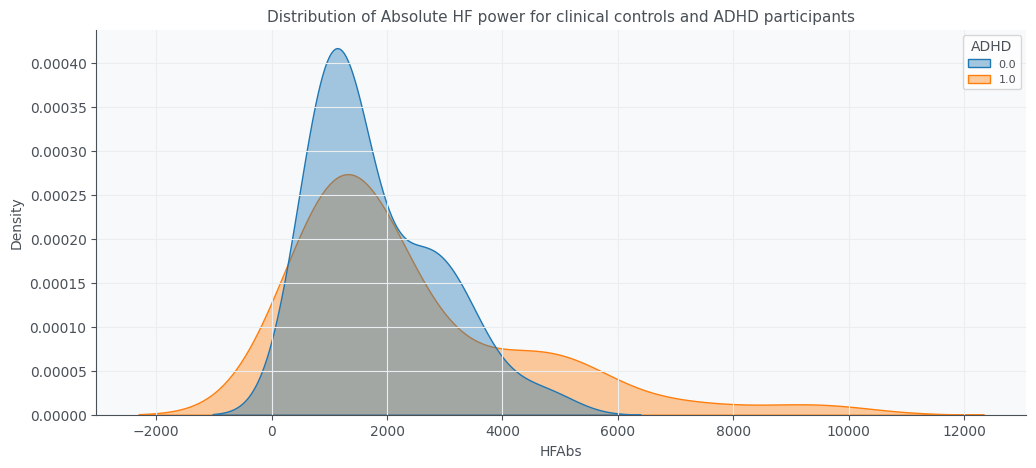

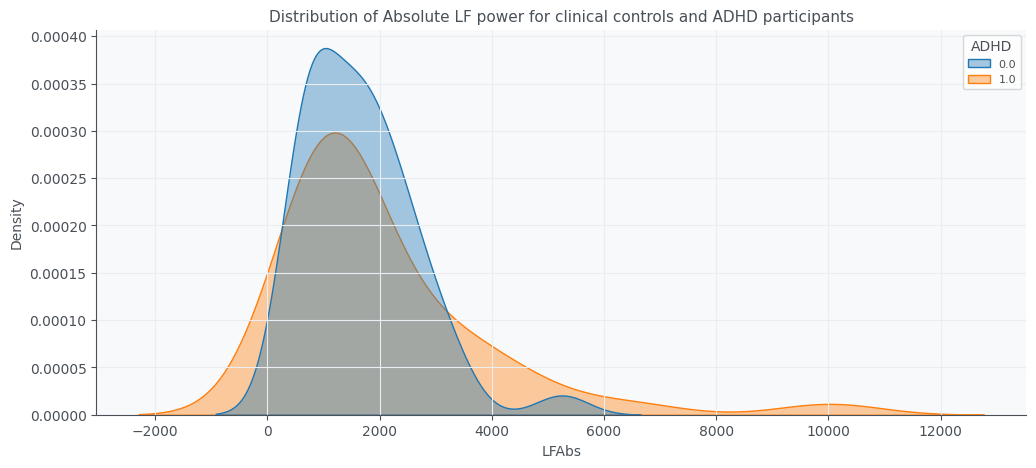

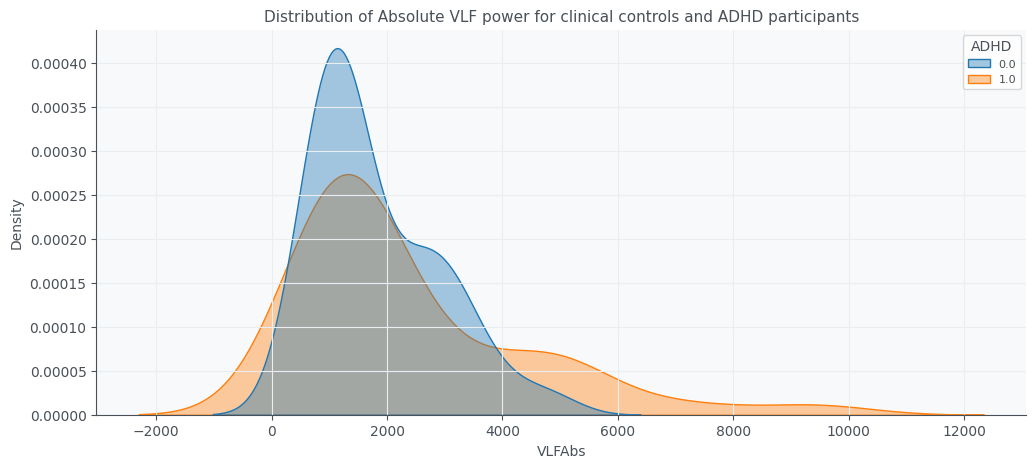

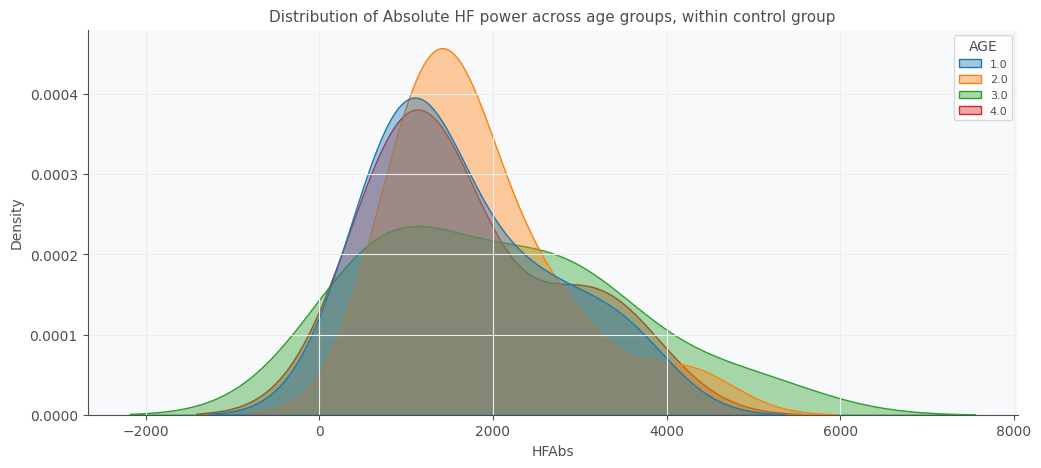

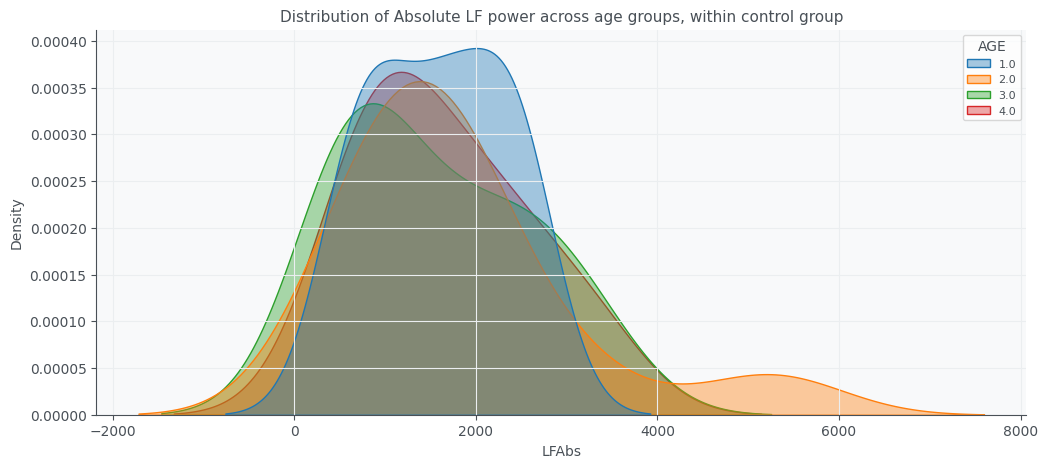

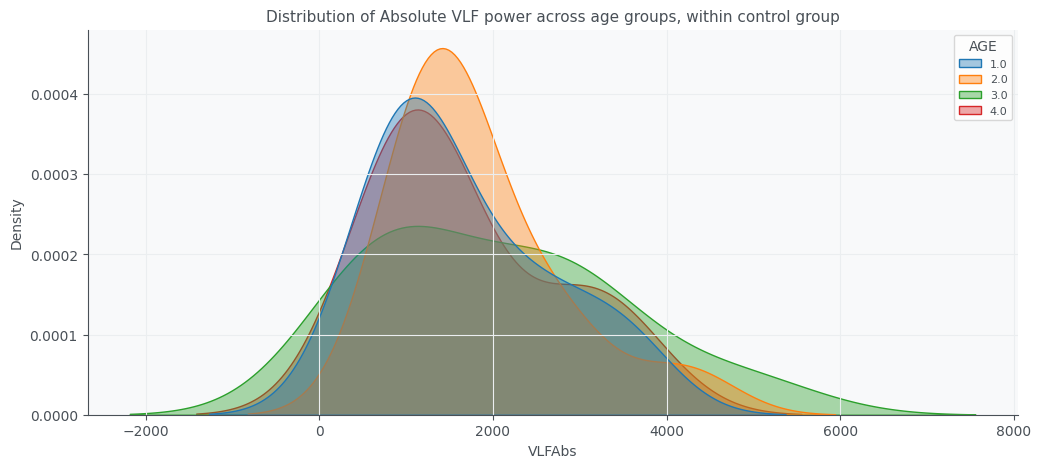

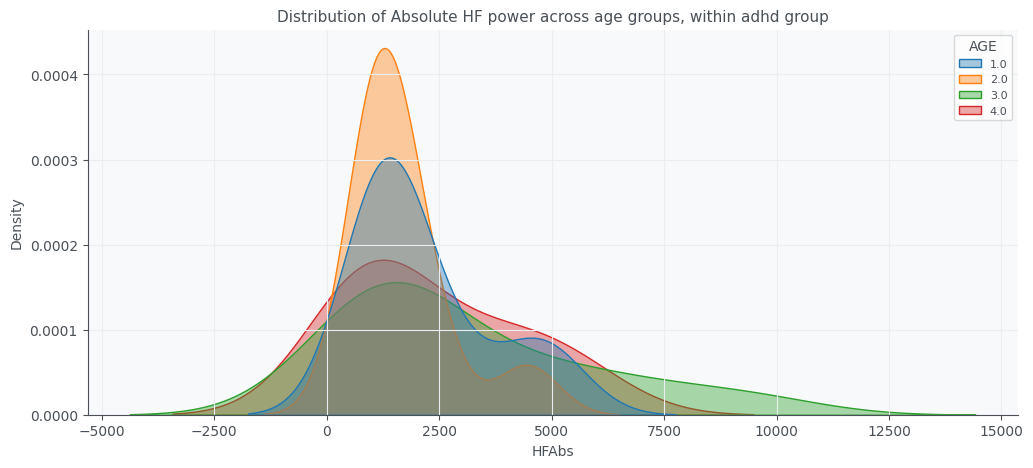

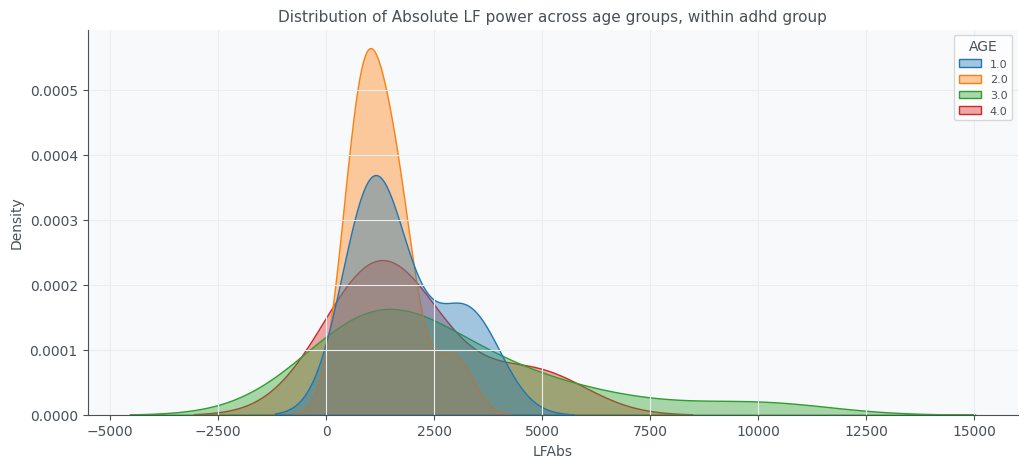

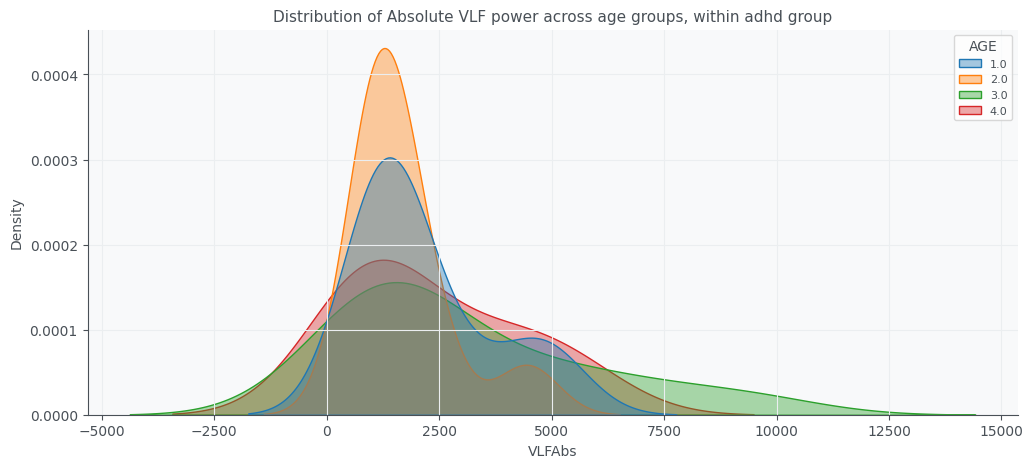

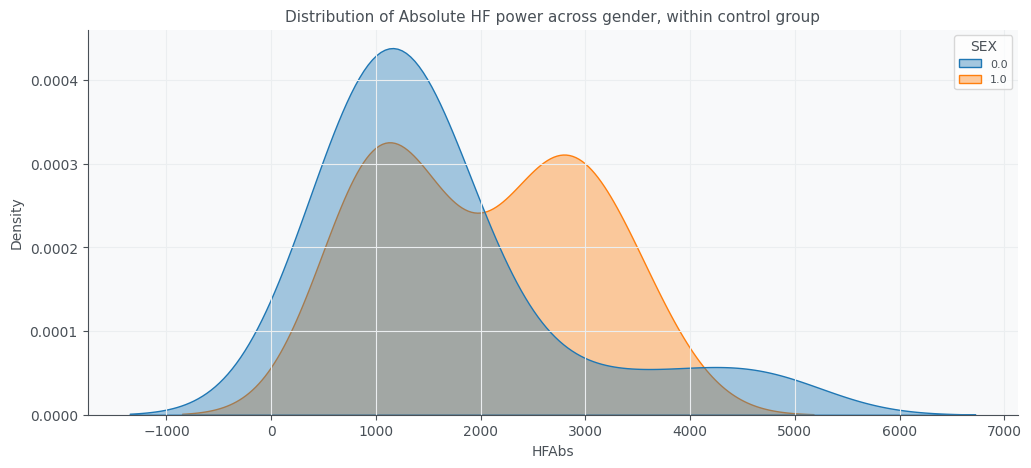

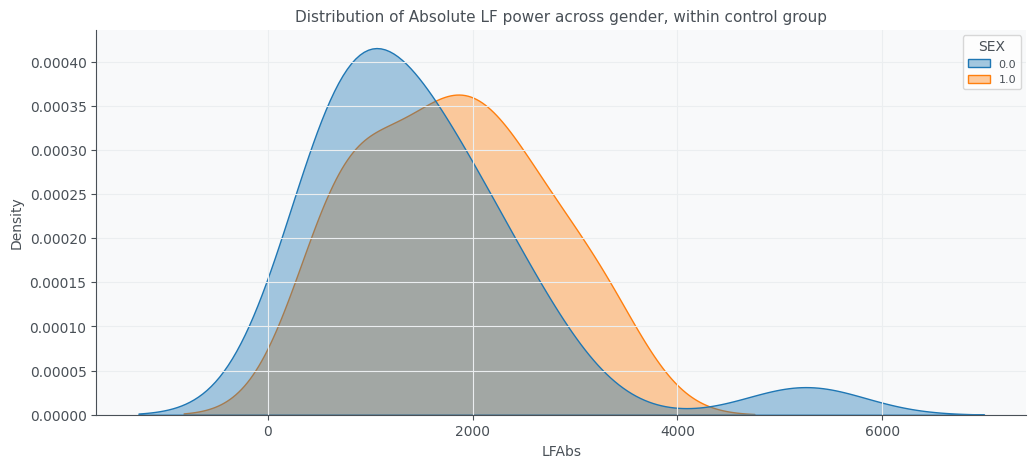

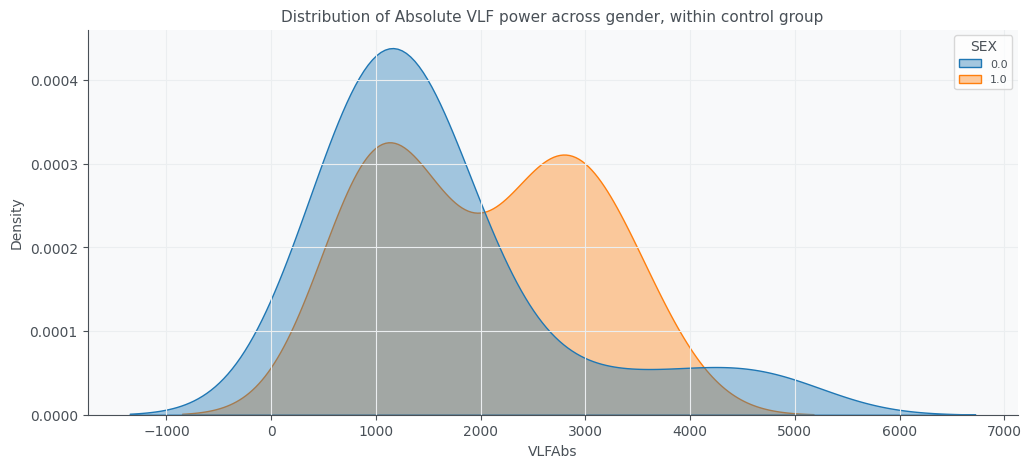

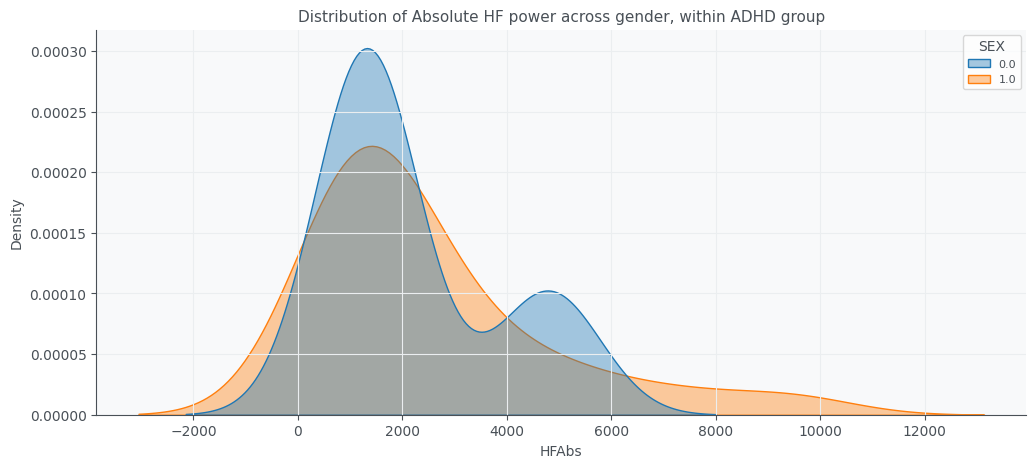

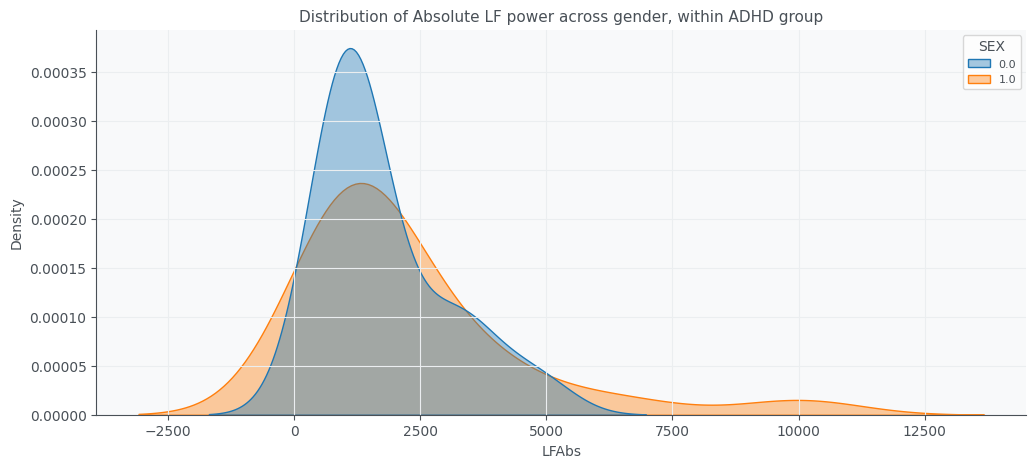

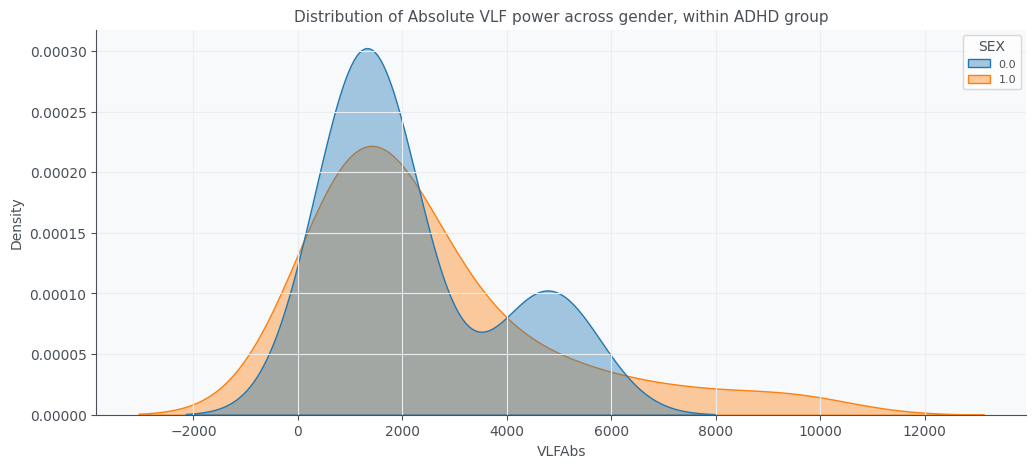

In [33]:
%matplotlib inline

# Plot
# Density plot 

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control - ABSOLUTE POWER
sns.kdeplot(data=Fre_df, x="HFAbs", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=Fre_df, x="LFAbs", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=Fre_df, x="VLFAbs", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute VLF power for clinical controls and ADHD participants')
plt.show()


# Subset according to participant groups
Fre_adhd = Fre_df.loc[(Fre_df['ADHD']== 1)]
Fre_control = Fre_df.loc[(Fre_df['ADHD'] == 0)]


# Different age groups - control
sns.kdeplot(data=Fre_control, x="HFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power across age groups, within control group')
plt.show()

sns.kdeplot(data=Fre_control, x="LFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power across age groups, within control group')
plt.show()

sns.kdeplot(data=Fre_control, x="VLFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute VLF power across age groups, within control group')
plt.show()


# Different age groups - adhd
sns.kdeplot(data=Fre_adhd, x="HFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power across age groups, within adhd group')
plt.show()

sns.kdeplot(data=Fre_adhd, x="LFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power across age groups, within adhd group')
plt.show()

sns.kdeplot(data=Fre_adhd, x="VLFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute VLF power across age groups, within adhd group')
plt.show()

# Gender - control
sns.kdeplot(data=Fre_control, x="HFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power across gender, within control group')
plt.show()

sns.kdeplot(data=Fre_control, x="LFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power across gender, within control group')
plt.show()

sns.kdeplot(data=Fre_control, x="VLFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute VLF power across gender, within control group')
plt.show()

# Gender - adhd
sns.kdeplot(data=Fre_adhd, x="HFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power across gender, within ADHD group')
plt.show()

sns.kdeplot(data=Fre_adhd, x="LFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power across gender, within ADHD group')
plt.show()

sns.kdeplot(data=Fre_adhd, x="VLFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute VLF power across gender, within ADHD group')
plt.show()


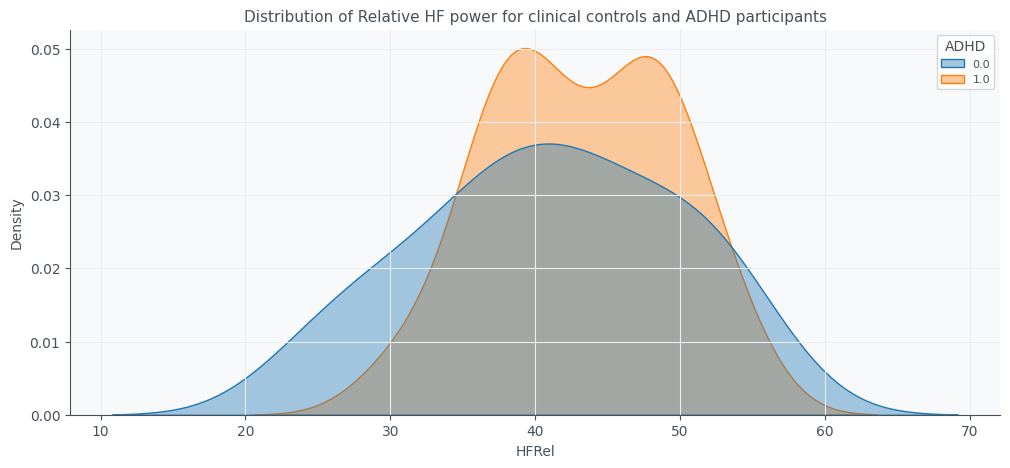

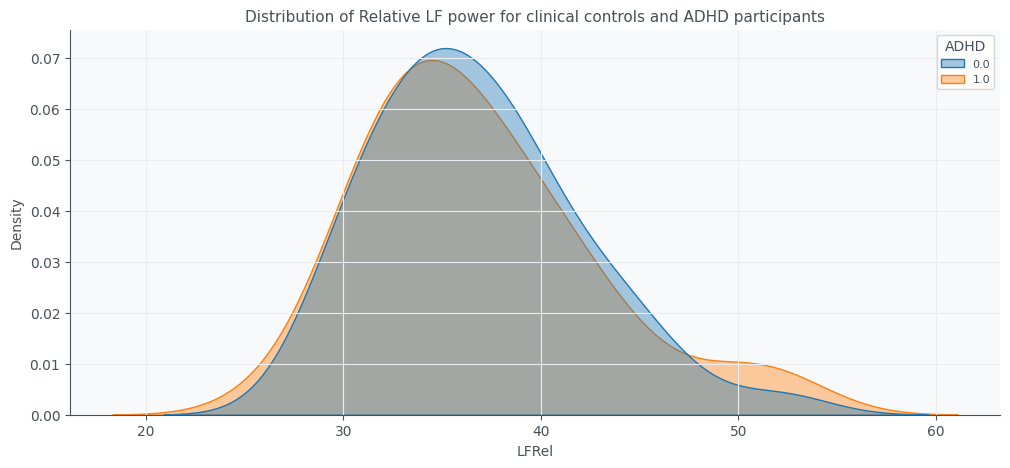

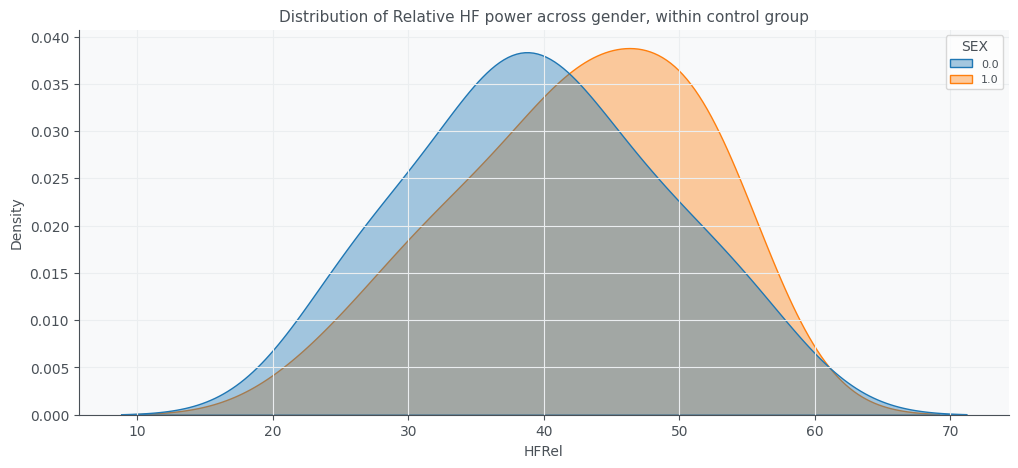

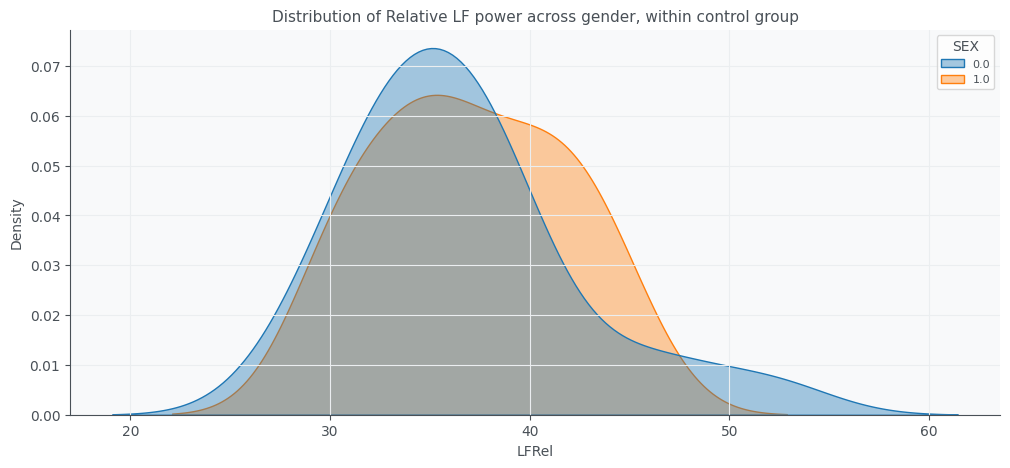

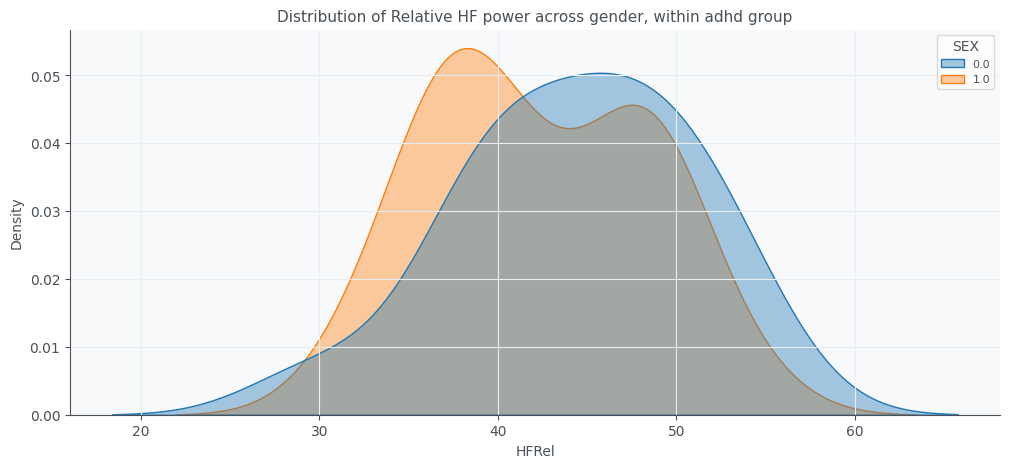

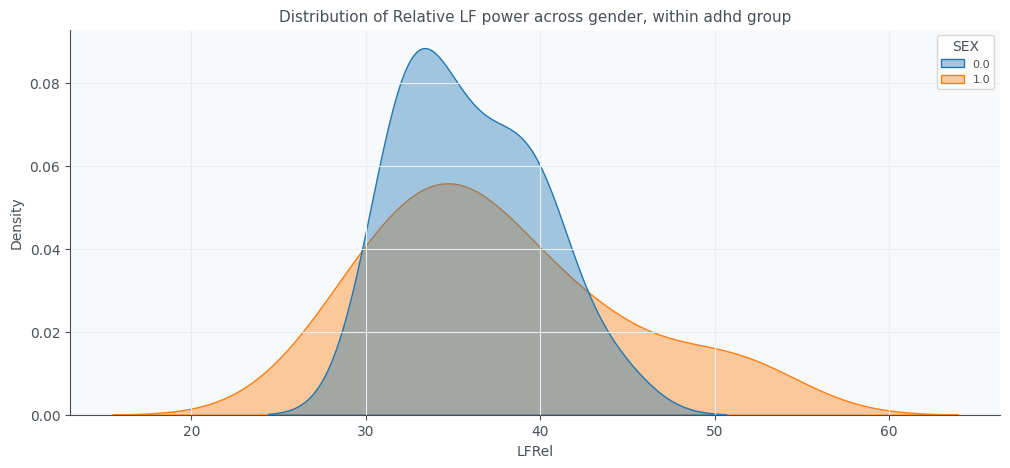

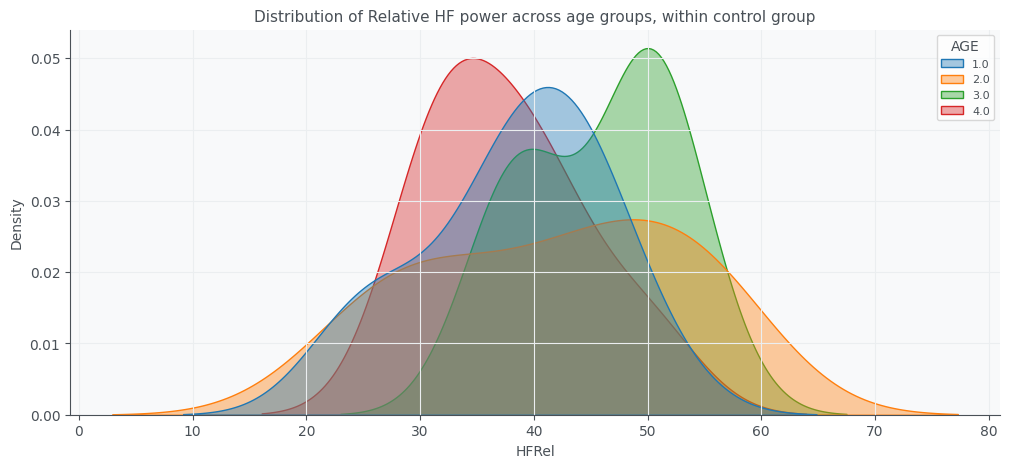

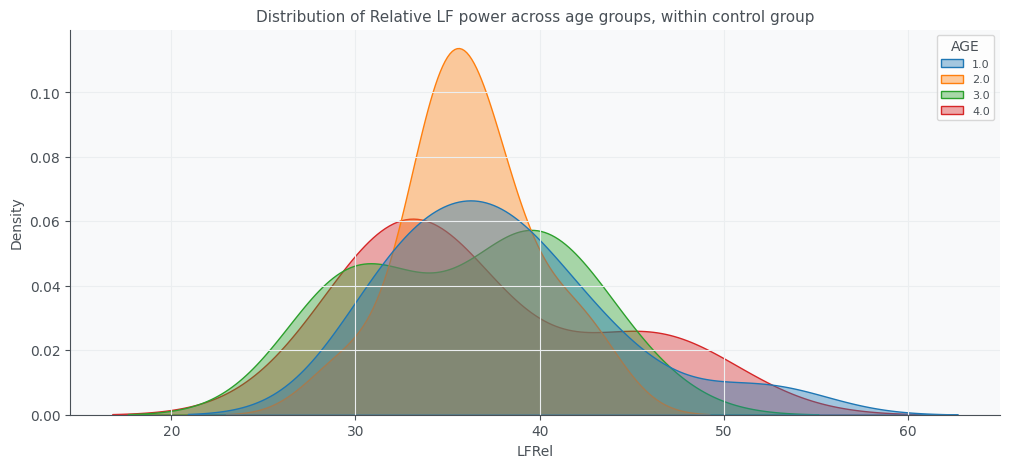

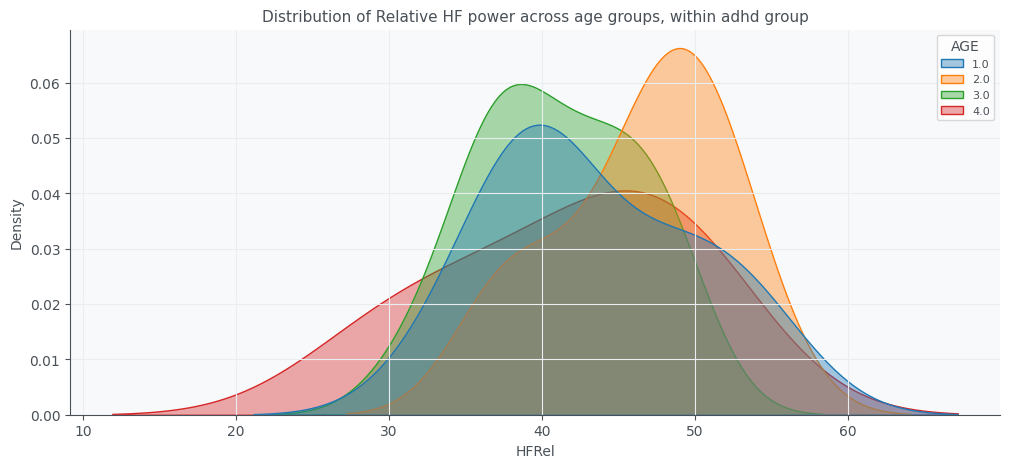

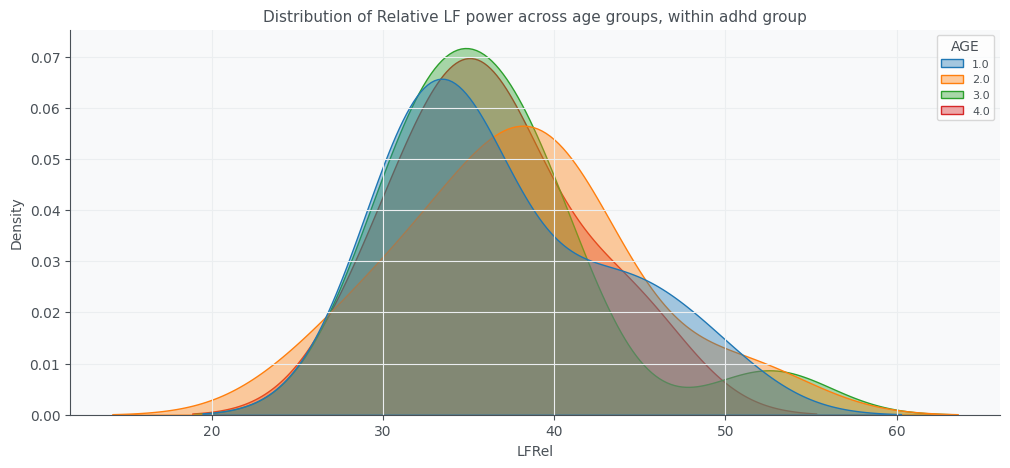

In [34]:
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control - RELATIVE POWER
sns.kdeplot(data=Fre_df, x="HFRel", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative HF power for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=Fre_df, x="LFRel", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative LF power for clinical controls and ADHD participants')
plt.show()


# Gender - control
sns.kdeplot(data=Fre_control, x="HFRel", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative HF power across gender, within control group')
plt.show()

sns.kdeplot(data=Fre_control, x="LFRel", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative LF power across gender, within control group')
plt.show()

# Gender - adhd
sns.kdeplot(data=Fre_adhd, x="HFRel", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative HF power across gender, within adhd group')
plt.show()

sns.kdeplot(data=Fre_adhd, x="LFRel", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative LF power across gender, within adhd group')
plt.show()



# Different age groups - control
sns.kdeplot(data=Fre_control, x="HFRel", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative HF power across age groups, within control group')
plt.show()

sns.kdeplot(data=Fre_control, x="LFRel", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative LF power across age groups, within control group')
plt.show()

# Different age groups - adhd
sns.kdeplot(data=Fre_adhd, x="HFRel", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative HF power across age groups, within adhd group')
plt.show()

sns.kdeplot(data=Fre_adhd, x="LFRel", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Relative LF power across age groups, within adhd group')
plt.show()



Modelling

In [35]:
# I will be focusing on absolute, and relative power

# Absolute power - HF / LF / VLF
HFabs_model = smf.ols(formula="HFAbs ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(HFabs_model.summary())

LFabs_model = smf.ols(formula="LFAbs ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(LFabs_model.summary())

VLFabs_model = smf.ols(formula="VLFAbs ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(VLFabs_model.summary())


# Relative power - HF / LF / VLF
HFrel_model = smf.ols(formula="HFRel ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(HFrel_model.summary())

LFrel_model = smf.ols(formula="LFRel ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(LFrel_model.summary())

VLFrel_model = smf.ols(formula="VLFRel ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(VLFrel_model.summary())



                            OLS Regression Results                            
Dep. Variable:                  HFAbs   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.647
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.108
Time:                        10:53:51   Log-Likelihood:                -702.37
No. Observations:                  80   AIC:                             1409.
Df Residuals:                      78   BIC:                             1414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1806.6598    245.802      7.350      

Non-linear Methods - Poincaré plot

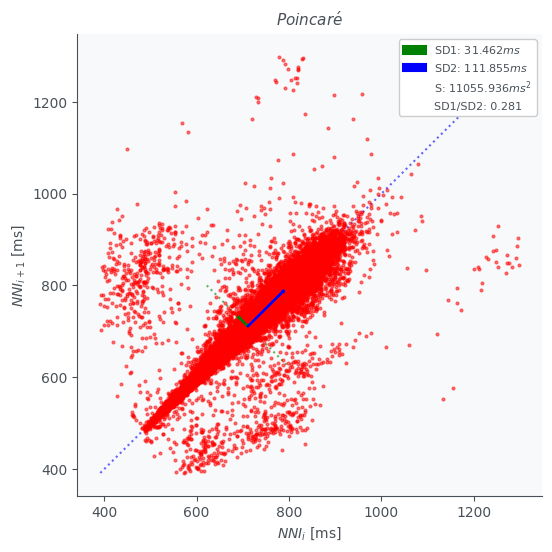

ReturnTuple(poincare_plot=<Figure size 600x600 with 1 Axes>, sd1=31.462297283036786, sd2=111.8549538604434, sd_ratio=3.5552061839028877, ellipse_area=11055.936254853408)

In [36]:
# Trying the nonlinear.poincare function from the pyhrv module, on participant 1
nonlinear.poincare(HRV_1_cor, ellipse=True)

Creating a function and a loop for non-linear analysis of all participants

In [37]:
# Create a function for non-linear analysis that extracts the non-linear metrics into a list.

def nonlin(x):
    results = nonlinear.poincare(x, ellipse=True)
    sd1 = results['sd1']
    sd2 = results['sd2']
    sdr = sd1/sd2
    ela = results['ellipse_area']
    results = [sd1, sd2, sdr, ela]
    return results



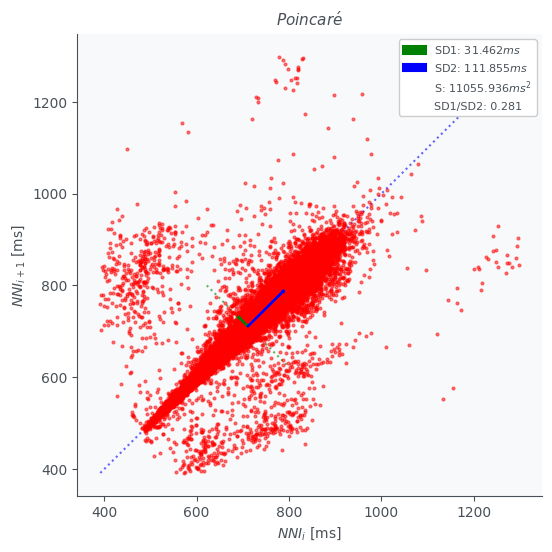

[31.462297283036786, 111.8549538604434, 0.2812776385594056, 11055.936254853408]

In [38]:
# Testing the function on participant 1
nonlin(HRV_1_cor)

In [39]:
%matplotlib agg
#Remove the line of code above if you wish to see all 80 Poincaré plots created for each participant

# Create a list object 
nonl_data = []

# Create list of datafiles

data_filesf = glob.glob("hyperaktiv/hrv_data/*.csv")

# For every file in the hrv_data folder:
for file in data_filesf:
    data = pd.read_csv(file, sep = ";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])
    data = data[(data.index.hour >= 8) & (data.index.hour <= 20)]
    data['HRV'] = np.where((300 <= data['HRV']) & (data['HRV'] <= 1300), data['HRV'], np.nan)
    data['HRV'] = data['HRV'].interpolate(method='linear', axis=0).ffill().bfill()
    results = nonlin(data)
    nonl_data.append(results)



# Convert list to dataframe
nonl_df = pd.DataFrame(nonl_data)
# Print head of the dataframe
    
nonl_df.head()

c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is

,0,1,2,3
0,31.462297,111.854954,0.281278,11055.936255
1,61.415260,305.042881,0.201333,58855.500916
2,33.879838,173.921762,0.194799,18511.649753
3,25.111868,141.324394,0.177690,11149.259700
4,32.245824,131.459422,0.245291,13317.265680


In [40]:
# Change column names
nonl_df.columns = ["SD1", "SD2", "Ratio", "S"]

nonl_df.head()

,SD1,SD2,Ratio,S
0,31.462297,111.854954,0.281278,11055.936255
1,61.415260,305.042881,0.201333,58855.500916
2,33.879838,173.921762,0.194799,18511.649753
3,25.111868,141.324394,0.177690,11149.259700
4,32.245824,131.459422,0.245291,13317.265680


In [41]:
# Add participant group, age, sex, HRV_Hours
extract = HRV_DF[["ADHD", "AGE", "SEX", "HRV_HOURS"]]

extract = extract.reset_index(drop=True)

nonl_df = extract.join(nonl_df)
nonl_df.head()


,ADHD,AGE,SEX,HRV_HOURS,SD1,SD2,Ratio,S
0,1,3,0,21.0,31.462297,111.854954,0.281278,11055.936255
1,1,2,1,21.0,61.415260,305.042881,0.201333,58855.500916
2,1,3,1,22.0,33.879838,173.921762,0.194799,18511.649753
3,1,1,1,12.0,25.111868,141.324394,0.177690,11149.259700
4,0,3,0,21.0,32.245824,131.459422,0.245291,13317.265680


In [42]:
nonl_df["HRV_HOURS"] = nonl_df["HRV_HOURS"].astype("category")

Visualising

In [43]:

# Visualize
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=nonl_df, x="SD1", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="SD2", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="Ratio", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="S", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S for clinical controls and ADHD participants')
plt.show()



C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\4002420051.py:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\4002420051.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\4002420051.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\4002420051.py:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [44]:
# Create subset for each participant group
nonl_adhd = nonl_df.loc[(nonl_df['ADHD']== 1)]
nonl_control = nonl_df.loc[(nonl_df['ADHD'] == 0)]

In [45]:
# Density distribution across gender, for each participant group
sns.kdeplot(data=nonl_control, x="SD1", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 across gender, within control group')
plt.show()

sns.kdeplot(data=nonl_control, x="SD2", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 across gender, within control group')
plt.show()

sns.kdeplot(data=nonl_control, x="Ratio", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio across gender, within control group')
plt.show()

sns.kdeplot(data=nonl_control, x="S", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S across gender, within control group')
plt.show()

#######

sns.kdeplot(data=nonl_adhd, x="SD1", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 across gender, within adhd group')
plt.show()

sns.kdeplot(data=nonl_adhd, x="SD2", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 across gender, within adhd group')
plt.show()

sns.kdeplot(data=nonl_adhd, x="Ratio", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio across gender, within adhd group')
plt.show()

sns.kdeplot(data=nonl_adhd, x="S", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S across gender, within adhd group')
plt.show()


C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2396707105.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2396707105.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2396707105.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2396707105.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2396707105.py:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2396707105.py:26: UserWarning: M

In [46]:
# Density distribution across age groups, for control group
sns.kdeplot(data=nonl_control, x="SD1", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 across age groups, within control group')
plt.show()

sns.kdeplot(data=nonl_control, x="SD2", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 across age groups, within control group')
plt.show()

sns.kdeplot(data=nonl_control, x="Ratio", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio across age groups, within control group')
plt.show()

sns.kdeplot(data=nonl_control, x="S", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S across age groups, within control group')
plt.show()

##### Density distribution across age groups, for adhd group

sns.kdeplot(data=nonl_adhd, x="SD1", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 across age groups, within adhd group')
plt.show()

sns.kdeplot(data=nonl_adhd, x="SD2", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 across age groups, within adhd group')
plt.show()

sns.kdeplot(data=nonl_adhd, x="Ratio", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio across age groups, within adhd group')
plt.show()

sns.kdeplot(data=nonl_adhd, x="S", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S across age groups, within adhd group')
plt.show()




C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2982583450.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2982583450.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2982583450.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2982583450.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2982583450.py:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2982583450.py:26: UserWarning: M

Modelling

In [47]:
# Building models

SD1_model = smf.ols(formula="SD1 ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = nonl_df).fit()
print(SD1_model.summary())

SD2_model = smf.ols(formula="SD2 ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = nonl_df).fit()
print(SD2_model.summary())

SDratio_model = smf.ols(formula="Ratio ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = nonl_df).fit()
print(SDratio_model.summary())


                            OLS Regression Results                            
Dep. Variable:                    SD1   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6446
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.424
Time:                        10:54:27   Log-Likelihood:                -355.73
No. Observations:                  80   AIC:                             715.5
Df Residuals:                      78   BIC:                             720.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.5655      3.227     12.261      0.0

**Extra** 

Investigating whether medication might have an effect

In [48]:
#  Adding the MED column from patient_info
som = patient_info[patient_info['HRV']==1]

med = som[["MED"]] # Extract medication column
med = med.reset_index(drop=True)
hrvcopy = med.join(HRV_df)
hrvcopy.head()

hrvcopyad = hrvcopy[hrvcopy['ADHD']==1]
hrvcopyad.head()

,MED,ADHD,AGE,SEX,HRV_HOURS,Mean IBI,SDNN,Mean HR,STD HR,Min HR,Max HR,RMSSD,NN50,pNN50
0,1,1,3,0,21.0,711.032,82.162,84.384,10.443,46.230,153.218,44.494,2133,4.161
1,0,1,2,1,21.0,759.993,220.028,78.948,26.338,46.161,199.481,86.854,10657,21.935
2,1,1,3,1,22.0,634.521,125.293,94.560,17.988,46.195,198.834,47.913,2936,4.561
3,0,1,1,1,12.0,663.711,101.498,90.401,12.656,46.475,199.481,35.514,4202,6.917
6,0,1,3,1,24.0,625.943,208.121,95.855,38.716,46.335,199.481,136.342,18527,30.048


In [49]:
hrvcopyad["MED"].value_counts()

0    27
1    11
Name: MED, dtype: int64

In [50]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5

# ADHD vs clinical control
sns.kdeplot(data=hrvcopyad, x="SDNN", hue="MED", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN for ADHD participants, coloured by medication')
plt.show()

# ADHD vs clinical control
sns.kdeplot(data=hrvcopyad, x="RMSSD", hue="MED", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of RMSSD for ADHD participants, coloured by medication')
plt.show()

# ADHD vs clinical control
sns.kdeplot(data=hrvcopyad, x="pNN50", hue="MED", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of pNN50 ADHD participants, coloured by medication')
plt.show()

C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\394244554.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\394244554.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\394244554.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Investigating bimodality

In [51]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis. Colour by participant group
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['ADHD'], legend='full', ax=ax)


# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis. Colour by sex, within adhd group
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=adhd['SDNN'], y=adhd['HRV_HOURS'], hue=adhd['SEX'], legend='full', ax=ax)


# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis. Colour by sex
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['SEX'], legend='full', ax=ax)


# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis. Colour by sex, within control group
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=control['SDNN'], y=control['HRV_HOURS'], hue=control['SEX'], legend='full', ax=ax)

<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

In [52]:
# Try to plot comorbidities to see whether they may be influencing or causing the bimodality
patient_info = patient_info[patient_info['HRV']==1]
patient_info = patient_info[["ID", "SEX", "AGE", "ADHD", "HRV", "HRV_TIME", "HRV_HOURS", "ADD", "BIPOLAR", "UNIPOLAR", "ANXIETY"]]

conditions = [
    (patient_info["ADD"] == 1),
    (patient_info["BIPOLAR"] == 1),
    (patient_info["UNIPOLAR"] == 1),
    (patient_info["ANXIETY"] == 1)
]

co = ["ADD", "BIPOLAR", "UNIPOLAR", "ANXIETY"]

HRV_df["comor"] = np.select(conditions, co)

# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['comor'], style=HRV_df['ADHD'], legend='full', ax=ax)
plt.show()


bip = HRV_df.loc[(HRV_df["comor"] == "BIPOLAR")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=bip['SDNN'], y=bip['HRV_HOURS'], legend='full', ax=ax)
plt.title("BIPOLAR")
plt.show()


add = HRV_df.loc[(HRV_df["comor"] == "ADD")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=add['SDNN'], y=add['HRV_HOURS'], legend='full', ax=ax)
plt.title("ADD")
plt.show()

uni = HRV_df.loc[(HRV_df["comor"] == "UNIPOLAR")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=uni['SDNN'], y=uni['HRV_HOURS'], legend='full', ax=ax)
plt.title("UNIPOLAR DEPRESSION")
plt.show()

anx = HRV_df.loc[(HRV_df["comor"] == "ANXIETY")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=anx['SDNN'], y=anx['HRV_HOURS'], legend='full', ax=ax)
plt.title("ANXIETY")
plt.show()



C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\3274227518.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\3274227518.py:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\3274227518.py:34: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\3274227518.py:40: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\3274227518.py:46: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [53]:
# Comorbidities

sns.kdeplot(data=HRV_df, x="SDNN", hue="comor", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across comorbidity groups')
plt.show()

sns.kdeplot(data=HRV_df, x="RMSSD", hue="comor", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of RMSSD across comorbidity groups')
plt.show()

sns.kdeplot(data=HRV_df, x="pNN50", hue="comor", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of pNN50 across comorbidity groups')
plt.show()

C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\1205895478.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\1205895478.py:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\1205895478.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


QQ plots and residual plots

eval_env: 1


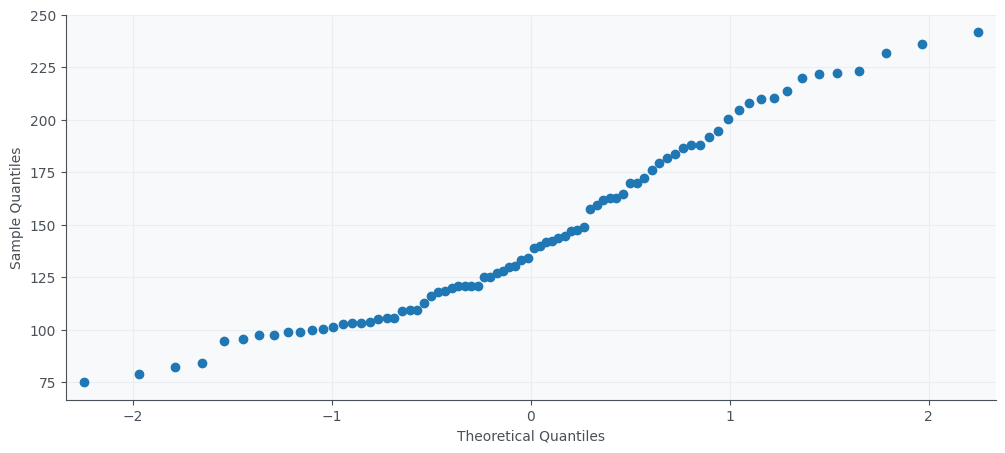

In [54]:
fig= plt.figure(figsize=(15,7))

fig = sm.graphics.plot_regress_exog(model1s, "ADHD", fig=fig)

sm.qqplot(HRV_df["SDNN"])

Levene's test 

In [55]:
# Define a function that runs Levene's test for the last 9 columns in the dataframe

def lev(x, y, *args):
    test_results = {}

    test_results['Mean IBI'] = levene(x['Mean IBI'], y['Mean IBI'])
    test_results['SDNN'] = levene(x['SDNN'], y['SDNN'])
    test_results['Mean HR'] = levene(x['Mean HR'], y['Mean HR'])
    test_results['STD HR'] = levene(x['STD HR'], y['STD HR'])
    test_results['Min HR'] = levene(x['Min HR'], y['Min HR'])
    test_results['Max HR'] = levene(x['Max HR'], y['Max HR'])
    test_results['RMSSD'] = levene(x['RMSSD'], y['RMSSD'])
    test_results['NN50'] = levene(x['NN50'], y['NN50'])
    test_results['pNN50'] = levene(x['pNN50'], y['pNN50'])

    test_results = pd.DataFrame.from_dict(test_results)
    test_results.index = ["statistic", "P-value"]
    return test_results





In [57]:
## Subset data
adhd_m = HRV_df.loc[(HRV_df['ADHD']== 1) & (HRV_df['SEX']== 1)]
adhd_f = HRV_df.loc[(HRV_df['ADHD']== 1) & (HRV_df['SEX']== 0)]

# Control - male vs female *
control_m = HRV_df.loc[(HRV_df['ADHD']== 0) & (HRV_df['SEX']== 1)]
control_f = HRV_df.loc[(HRV_df['ADHD']== 0) & (HRV_df['SEX']== 0)]

# All male vs female (regardless of participant group) *
male = HRV_df.loc[(HRV_df['SEX']== 1)]
female = HRV_df.loc[(HRV_df['SEX']== 0)]

# All Age groups *
age1 = HRV_df.loc[(HRV_df['AGE']== 1)]
age2 = HRV_df.loc[(HRV_df['AGE']== 2)]
age3 = HRV_df.loc[(HRV_df['AGE']== 3)]
age4 = HRV_df.loc[(HRV_df['AGE']== 4)]

# ADHD - age groups *
adhdage1 = HRV_df.loc[(HRV_df['AGE']== 1)&(HRV_df['ADHD']== 1)]
adhdage2 = HRV_df.loc[(HRV_df['AGE']== 2)&(HRV_df['ADHD']== 1)]
adhdage3 = HRV_df.loc[(HRV_df['AGE']== 3)&(HRV_df['ADHD']== 1)]
adhdage4 = HRV_df.loc[(HRV_df['AGE']== 4)&(HRV_df['ADHD']== 1)]

# Control - age groups *
controlage1 = HRV_df.loc[(HRV_df['AGE']== 1)&(HRV_df['ADHD']== 0)]
controlage2 = HRV_df.loc[(HRV_df['AGE']== 2)&(HRV_df['ADHD']== 0)]
controlage3 = HRV_df.loc[(HRV_df['AGE']== 3)&(HRV_df['ADHD']== 0)]
controlage4 = HRV_df.loc[(HRV_df['AGE']== 4)&(HRV_df['ADHD']== 0)]

In [58]:
aa = lev(adhd, control)
bb = lev(adhd_m, adhd_f)
cc = lev(control_m, control_f)
dd = lev(male, female)
ee = lev(age1, age2, age3, age4)
ff = lev(adhdage1, adhdage2, adhdage3, adhdage4)
gg = lev(controlage1, controlage2, controlage3, controlage4)

print(aa)
print(bb)
print(cc)
print(dd)
print(ee)
print(ff)
print(gg)

           Mean IBI      SDNN   Mean HR    STD HR    Min HR    Max HR  \
statistic  0.390977  1.208588  0.087964  1.810781  0.352093  0.975029   
P-value    0.533611  0.274993  0.767570  0.182313  0.554648  0.326482   

              RMSSD      NN50     pNN50  
statistic  1.896253  0.350756  0.998622  
P-value    0.172438  0.555398  0.320734  
           Mean IBI      SDNN   Mean HR    STD HR    Min HR    Max HR  \
statistic  0.131803  3.970917  0.331100  0.147030  0.121822  1.821049   
P-value    0.718693  0.053916  0.568591  0.703645  0.729100  0.185614   

              RMSSD      NN50     pNN50  
statistic  2.375437  1.958340  1.265391  
P-value    0.132002  0.170249  0.268078  
           Mean IBI      SDNN   Mean HR    STD HR    Min HR    Max HR  \
statistic  0.087941  0.730728  0.009781  1.445755  0.504490  5.433996   
P-value    0.768346  0.397739  0.921712  0.236280  0.481655  0.024874   

              RMSSD      NN50    pNN50  
statistic  0.000077  0.180611  0.15451  
P-valu

In [59]:
# Define a function that runs T-test for the last 9 columns in the dataframe

def ttest(x, y):
    test_results = {}

    test_results['Mean IBI'] = stats.ttest_ind(x['Mean IBI'], y['Mean IBI'], equal_var=True)
    test_results['SDNN'] = stats.ttest_ind(x['SDNN'], y['SDNN'], equal_var=True)
    test_results['Mean HR'] = stats.ttest_ind(x['Mean HR'], y['Mean HR'], equal_var=True)
    test_results['STD HR'] = stats.ttest_ind(x['STD HR'], y['STD HR'], equal_var=True)
    test_results['Min HR'] = stats.ttest_ind(x['Min HR'], y['Min HR'], equal_var=True)
    test_results['Max HR'] = stats.ttest_ind(x['Max HR'], y['Max HR'], equal_var=True)
    test_results['RMSSD'] = stats.ttest_ind(x['RMSSD'], y['RMSSD'], equal_var=True)
    test_results['NN50'] = stats.ttest_ind(x['NN50'], y['NN50'], equal_var=True)
    test_results['pNN50'] = stats.ttest_ind(x['pNN50'], y['pNN50'], equal_var=True)

    test_results = pd.DataFrame.from_dict(test_results)
    test_results.index = ["T-score", "P-value"]
    return test_results



In [60]:
# T-test
a = ttest(adhd, control) # main hypothesis
b = ttest(control_m, control_f) # sanity check
c = ttest(adhd_m, adhd_f)
d = ttest(adhd_m, control_m)
e = ttest(adhd_f, control_f)

print(a)
print(b)
print(c)
print(d)
print(e)

         Mean IBI      SDNN   Mean HR    STD HR    Min HR    Max HR     RMSSD  \
T-score -0.853708  1.595443  0.814522  1.648894 -0.436448  0.976115  0.802906   
P-value  0.395881  0.114657  0.417826  0.103192  0.663717  0.332025  0.424469   

             NN50     pNN50  
T-score  0.207976  0.449052  
P-value  0.835790  0.654639  
         Mean IBI      SDNN   Mean HR    STD HR    Min HR    Max HR     RMSSD  \
T-score  1.096413 -0.102683 -0.992223 -0.874466  0.636376 -2.170063  0.155879   
P-value  0.279455  0.918728  0.327053  0.387085  0.528156  0.035998  0.876912   

             NN50     pNN50  
T-score  0.202409  0.621116  
P-value  0.840623  0.538047  
         Mean IBI      SDNN   Mean HR    STD HR    Min HR    Max HR     RMSSD  \
T-score -0.816530  0.657128  0.896888  0.238581  0.220997  1.349462  0.837237   
P-value  0.419568  0.515278  0.375737  0.812783  0.826344  0.185614  0.407983   

             NN50     pNN50  
T-score  0.321188  0.422563  
P-value  0.749925  0.675127 

Scatterplots to check whether recording length affects data

In [62]:
# Scatterplots
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=Fre_df['HRV_HOURS'], y=Fre_df['HFAbs'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=Fre_df['HRV_HOURS'], y=Fre_df['LFAbs'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=Fre_df['HRV_HOURS'], y=Fre_df['VLFAbs'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=Fre_df['HRV_HOURS'], y=Fre_df['HFRel'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=Fre_df['HRV_HOURS'], y=Fre_df['LFRel'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=Fre_df['HRV_HOURS'], y=Fre_df['VLFRel'], legend='full', ax=ax)
plt.show()

C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2279593582.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2279593582.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2279593582.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2279593582.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2279593582.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\2279593582.py:24: UserWarning: M

Check whether comorbidities seem to have an effect

In [63]:
# Comorbidities - I NEED TO ADD COMORBIDITIES TO THIS DATASET FIRST

# sns.kdeplot(data=Fre_df, x="HFabs", hue="comor", fill=True, common_norm=False, alpha=0.4)
# plt.title('Distribution of SDNN across comorbidity groups')
# plt.show()

# sns.kdeplot(data=Fre_df, x="LFAbs", hue="comor", fill=True, common_norm=False, alpha=0.4)
# plt.title('Distribution of RMSSD across comorbidity groups')
# plt.show()

# sns.kdeplot(data=Fre_df, x="VLFAbs", hue="comor", fill=True, common_norm=False, alpha=0.4)
# plt.title('Distribution of pNN50 across comorbidity groups')
# plt.show()

Scatterplots to see whether recording length affects the data

In [64]:
# Scatterplots
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=nonl_df['SD1'], y=nonl_df['HRV_HOURS'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=nonl_df['SD2'], y=nonl_df['HRV_HOURS'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=nonl_df['Ratio'], y=nonl_df['HRV_HOURS'], legend='full', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=nonl_df['S'], y=nonl_df['HRV_HOURS'], legend='full', ax=ax)
plt.show()

C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\423453386.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\423453386.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\423453386.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Gacil\AppData\Local\Temp\ipykernel_17720\423453386.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
